In [4]:
# if you want to run the pdb debugger, run this cell
%pdb on

Automatic pdb calling has been turned OFF



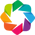

In [3]:
##### Setup/import packages
import os 
import glob
import trodes2SS
from trodes2SS import AttrDict, TrodesImport, convert_dan_posterior_to_xarray
import sungod_linearization
from sungod_linearization import createTrackGraph, hack_determinearmorder, turn_array_into_ranges, \
chunk_data, change_to_directory_make_if_nonexistent
import numpy as np
import scipy.io
import scipy as sp
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import holoviews as hv
import json
import functools
import dask
import dask.dataframe as dd
import dask.array as da
import networkx as nx
import loren_frank_data_processing as lfdp
import scipy.io as sio # for saving .mat files 
import inspect # for inspecting files (e.g. finding file source)
import multiprocessing 
import sys 
import pickle
from tempfile import TemporaryFile
from multiprocessing import Pool
import math 

path_main = '/home/anna/Src/spykshrk_realtime'
os.chdir(path_main)
from spykshrk.franklab.data_containers import FlatLinearPosition, SpikeFeatures, Posteriors, \
        EncodeSettings, pos_col_format, SpikeObservation, RippleTimes, DayEpochEvent, DayEpochTimeSeries
from spykshrk.franklab.pp_decoder.util import normal_pdf_int_lookup, gaussian, apply_no_anim_boundary, normal2D
from spykshrk.franklab.pp_decoder.pp_clusterless import OfflinePPEncoder, OfflinePPDecoder
from spykshrk.franklab.pp_decoder.visualization import DecodeVisualizer
from spykshrk.util import Groupby

hv.extension('matplotlib')
hv.extension('bokeh')
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 15)


%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['xtick.labelsize']=20
mpl.rcParams['ytick.labelsize']=20
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['axes.titlesize']=26

In [20]:
# Import data

# Define path bases 
#path_base_rawdata = '/mnt/vortex/mcoulter/raw_data/'
path_base_rawdata = '/data2/mcoulter/raw_data/'

# Define parameters
# for a 45 min runtime on virga use tetrodes 4,9,11,13,15,19,21,23,25,28,30
rat_name = 'remy'
directory_temp = path_base_rawdata + rat_name + '/'
day_dictionary = {'remy':[20], 'gus':[24], 'bernard':[23], 'fievel':[19]}
epoch_dictionary = {'remy':[2], 'gus':[2], 'bernard':[2], 'fievel':[2]} 
#tetrodes_dictionary = {'remy': [4,6,9,10,11,12,13,14,15,17,19,20,21,22,23,24,25,26,28,29,30], # 4,6,9,10,11,12,13,14,15,17,19,20,21,22,23,24,25,26,28,29,30
#                       'gus': [6,7,8,9,10,11,12,17,18,19,21,24,25,26,27,30], # list(range(6,13)) + list(range(17,22)) + list(range(24,28)) + [30]
#                        'bernard': [1,2,3,4,5,7,8,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29], 
#                       'fievel': [1,2,3,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,22,23,24,25,27,28,29]}
tetrodes_dictionary = {'remy': [4,9,11,13,15,19,21,23,25,28,30], 'gus': [6], 'bernard': [1], 'fievel': [1]}

# Maze information
os.chdir('/data2/mcoulter/maze_info/' + rat_name)
#maze_coordinates = scipy.io.loadmat('set_arm_nodes.mat',variable_names = 'linearcoord_NEW')
# new maze coordinates with only one segment for box
maze_coordinates = scipy.io.loadmat('set_arm_nodes.mat',variable_names = 'linearcoord_one_box')

datasrc = TrodesImport(directory_temp, rat_name, day_dictionary[rat_name], 
                       epoch_dictionary[rat_name], tetrodes_dictionary[rat_name])

# Import marks
marks = datasrc.import_marks()
# # os.chdir('/data2/jguidera/data/')
# # np.load('marks.npy')

# Import position #? concerned about use of sampling rate in the definition for position
# Temporary small definition of encoding settings-- need 'arm_coordinates' to use datasrc.import_pos 
encode_settings = AttrDict({'arm_coordinates': [[0,0]]})
# Import position (#? concerned about use of sampling rate in the definition for position)
pos = datasrc.import_pos(encode_settings, xy='x')
posY = datasrc.import_pos(encode_settings, xy='y')

# Import ripples
rips = datasrc.import_rips(pos, velthresh=4) # commented out until I get rips definition working

# Define path bases
path_base_dayepoch = 'day' + str(day_dictionary[rat_name][0]) + '_epoch' + str(epoch_dictionary[rat_name][0])
path_base_analysis = '/data2/mcoulter/maze_info/'


duplicates found & removed: 0


In [5]:
#filter ripples for velocity < 4
#re-shape ripples input table into format for get_irregular_resample
rips['timestamp'] = rips['starttime']
rips['time'] = rips['starttime']
rips.timestamp = rips.timestamp*30000
rips['timestamp'] = rips['timestamp'].astype(int)
rips.reset_index(level=['event'], inplace=True)
rips.columns = ['event','starttime','endtime','maxthresh','timestamp','time']
rips.set_index(['timestamp', 'time'], drop=True, append=True, inplace=True)

#filter for velocity < 4 with get_irregular_resample
linflat_obj = pos.get_mapped_single_axis()
linflat_ripindex = linflat_obj.get_irregular_resampled(rips)
linflat_ripindex_encode_velthresh = linflat_ripindex.query('linvel_flat < 4')

#re-shape to RippleTimes format for plotting
rips_vel_filt = rips.loc[linflat_ripindex_encode_velthresh.index]
rips_vel_filt.reset_index(level=['timestamp','time'], inplace=True)
rips_vel_filt.set_index(['event'], drop=True, append=True, inplace=True)
rips_vel_filtered = RippleTimes.create_default(rips_vel_filt, 1)

print('rips less than velocity 4: '+str(linflat_ripindex_encode_velthresh.shape[0]))

rips less than velocity 4: 1256


In [43]:
%%time
# linearize the whole epoch - this gets rid of the pos_subset variables and linearizes position of whole epoch

encode_settings = AttrDict({'arm_coordinates': [[0,0]]})
# variables for all position data
pos_all_linear = datasrc.import_pos(encode_settings, xy='x')
posY1 = datasrc.import_pos(encode_settings, xy='y')
speed_threshold_save = 0;

#linear_start = pos.index.get_level_values('time')[subset_start]
#linear_end = pos.index.get_level_values('time')[subset_end]

# Define path base
#path_base_timewindow = str(int(round(linear_start))) + 'to' + str(int(round(linear_end))) + 'sec'
path_base_timewindow = 'whole_epoch_v3'
path_base_foranalysisofonesessionepoch = path_base_analysis + rat_name + '/' + path_base_dayepoch + '/' + path_base_timewindow

# Change to directory with saved linearization result
# Define folder for saved linearization result 
linearization_output_save_path = path_base_foranalysisofonesessionepoch + '/linearization_output/'
linearization_output_save_path
# Check if it exists, make if it doesn't
directory_path = linearization_output_save_path
change_to_directory_make_if_nonexistent(directory_path)

# Define name of linearization result
linearization_output1_save_filename = 'linearization_' + path_base_timewindow + '_speed' + str(speed_threshold_save) + '_linear_distance_arm_shift' + '.npy'
linearization_output2_save_filename = 'linearization_' + path_base_timewindow + '_speed' + str(speed_threshold_save) + '_track_segment_id_use' + '.npy'
# If linearization exists
print('Linearization result exists. Loading it.')
linear_distance_arm_shift = np.load(linearization_output1_save_filename)
#test = np.load(linearization_output3_save_filename)
track_segment_id_use = np.load(linearization_output2_save_filename)
#pos_subset['linpos_flat'] = linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]
#for whole epoch 
pos_all_linear['linpos_flat'] = linear_distance_arm_shift

Linearization result exists. Loading it.
CPU times: user 408 ms, sys: 16 ms, total: 424 ms
Wall time: 424 ms


In [7]:
# Define position bins #!!! HARD CODE: ASSUMES POSITION BIN OF WIDTH 1 !!!
# need to use the indices of the encoding time subset in this cell

# Initialize variables 
tracksegment_positionvalues_min_and_max = []
tracksegment_positionvalues_for_bin_edges = [] 

#track_segment_id_use = track_segment_id

# Find min and max position for each track segment 
#tracksegments_temp = np.unique(track_segment_id_use[(subset_start-subset_start):(subset_end-subset_start+1)])
#whole epoch
tracksegments_temp = np.unique(track_segment_id_use[0:len(linear_distance_arm_shift)])

for t_loop in tracksegments_temp: # for each track segment
    #indiceswewant_temp = track_segment_id_use[(subset_start-subset_start):(subset_end-subset_start+1)] == t_loop
    #whole epoch
    indiceswewant_temp = track_segment_id_use[0:len(linear_distance_arm_shift)] == t_loop
    
    #tracksegment_positionvalues_temp = pos_subset.values[indiceswewant_temp,0] # second dimension of pos_subset: zero for position, 1 for velocity
    #whole epoch
    tracksegment_positionvalues_temp = pos_all_linear.values[indiceswewant_temp,0]
    
    tracksegment_positionvalues_min_and_max.append([tracksegment_positionvalues_temp.min(), tracksegment_positionvalues_temp.max()])
    # To define edges, floor mins and ceil maxes
    tracksegment_positionvalues_for_bin_edges.append([np.floor(tracksegment_positionvalues_temp.min()), np.ceil(tracksegment_positionvalues_temp.max())])

# Floor to get bins #? Is this right? Does 0 mean the bin spanning [0, 1]?
tracksegment_positionvalues_min_and_max_floor = np.floor(tracksegment_positionvalues_min_and_max)

# Find only bins in range of segments
binswewant_temp = []
for t_loop in tracksegment_positionvalues_min_and_max_floor: # for each track segment
    binswewant_temp.append(np.ndarray.tolist(np.arange(t_loop[0],t_loop[1] + 1))) # + 1 to account for np.arange not including last index
# Do same for edges
edgeswewant_temp = []
for t_loop in tracksegment_positionvalues_for_bin_edges: # for each track segment
    edgeswewant_temp.append(np.ndarray.tolist(np.arange(t_loop[0],t_loop[1] + 1))) # + 1 to account for np.arange not including last index

# Flatten (combine bins from segments)
binswewant_temp_flat = [y for x in binswewant_temp for y in x]
edgeswewant_temp_flat = [y for x in edgeswewant_temp for y in x]

# Find unique elements
arm_coords_wewant = (np.unique(binswewant_temp_flat))
edges_wewant = (np.unique(edgeswewant_temp_flat))

# Turn list of edges into ranges 
start_temp, end_temp = turn_array_into_ranges(edges_wewant)
arm_coordinates_WEWANT = np.column_stack((start_temp, end_temp))

# Print/plot
# Plot position values
# plt.plot(tracksegment_positionvalues_min_and_max_floor)
# print(arm_coords_wewant)
#print(arm_coordinates_WEWANT)
# type(arm_coords_wewant)
# plt.figure()
# plt.plot(arm_coords_wewant)


[[  0.  45.]
 [ 64. 128.]
 [147. 212.]
 [232. 297.]
 [319. 382.]
 [403. 466.]
 [485. 548.]
 [568. 629.]
 [649. 710.]]


In [44]:
# USE THIS CELL  - put positions into 5cm bins   
bins = np.array([0., 5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  64.,  69.,  74.,  79.,  84.,  89.,  94., 99., 104.,
       109., 114., 119., 124., 129., 135., 140., 145., 147., 152., 157.,
       162., 167., 172., 177., 182., 187., 192., 197., 202., 207., 212.,
       220., 225., 230., 232., 237., 242., 247., 252., 257., 262., 267.,
       272., 277., 282., 287., 292., 297., 305., 310., 315., 319., 324.,
       329., 334., 339., 344., 349., 354., 359., 364., 369., 374., 379.,
       384., 390., 395., 400., 403., 408., 413., 418., 423., 428., 433.,
       438., 443., 448., 453., 458., 463., 468., 475., 480., 485., 490.,
       495., 500., 505., 510., 515., 520., 525., 530., 535., 540., 545.,
       550., 555., 560., 565., 568., 573., 578., 583., 588., 593., 598.,
       603., 608., 613., 618., 623., 628., 633., 640., 645., 649., 654.,
       659., 664., 669., 674., 679., 684., 689., 694., 699., 704., 710.])
digitized = np.digitize(pos_all_linear['linpos_flat'], bins)
#pos_all_linear['linpos_flat'] = digitized
#pos_all_linear['linpos_flat'] = pos_all_linear['linpos_flat'] - 1
#print('position bins: ',bins)

In [ ]:
# ?? why substract 1 from the digitized position? 

In [ ]:
%%output backend='bokeh'
%%opts Histogram [height=300, width=400]
# plot validation of binning the positions into 5cm bins
hist1 = hv.Histogram((encoder.occupancy, encode_settings.pos_bin_edges))
hist2 = hv.Histogram(np.histogram(a=pos_subset['linpos_flat'], 
                                  bins=encode_settings.pos_bin_edges,normed=True))
layout = hv.Layout(hist1 + hist2).cols(2)
layout

In [64]:
digitized.min()

1

In [ ]:
    #define encoding settings
    #max_pos = int(round(linear_distance_arm_shift.max()) + 20)

    # if you are using 5cm position bins, use this max_pos instead
    #max_pos = int(round(linear_distance_arm_shift.max()/5)+5)

    # remove final 3 bins to see if there is a problem with occupancy normalization
#max_pos = int(round(linear_distance_arm_shift.max()/5)+2)
    
    # max position for 5 cm bins, not dividing by 5
# this is 1 bin past the end of the position bins
max_pos = 142

encode_settings = AttrDict({'sampling_rate': 3e4,
                                'pos_bins': np.arange(0,max_pos,1), # arm_coords_wewant
                                'pos_bin_edges': np.arange(0,max_pos + .1,1), # edges_wewant, 
                                'pos_bin_delta': 1, 
                                # 'pos_kernel': sp.stats.norm.pdf(arm_coords_wewant, arm_coords_wewant[-1]/2, 1),
                                'pos_kernel': sp.stats.norm.pdf(np.arange(0,max_pos,1), max_pos/2, 0.2), #note that the pos_kernel mean should be half of the range of positions (ie 180/90) # sp.stats.norm.pdf(np.arange(0,560,1), 280, 1),    
                                'pos_kernel_std': 0.2, 
                                'mark_kernel_std': int(20), 
                                'pos_num_bins': max_pos, # len(arm_coords_wewant)
                                'pos_col_names': [pos_col_format(ii, max_pos) for ii in range(max_pos)], # or range(0,max_pos,10)
                                'arm_coordinates': np.array([[0,8],[13,25],[30,42],[47,59],[64,76],[81,93],[97,109],[114,125],[130,141]])}) # old way: arm_coordinates_WEWANT includes box, removes bins in the gaps 'arm_coordinates': [[0,max_pos]]})

print('Encode settings: ',encode_settings)

    #cell 9
    #define decode settings
decode_settings = AttrDict({'trans_smooth_std': 2,
                                'trans_uniform_gain': 0.0001,
                                'time_bin_size':60})

#print('Decode settings: ',decode_settings)


In [22]:
    #cell 9.1 randomize trial order within epoch
    #read in trial times
trialsname = directory_temp+rat_name+'trials'+str(day_dictionary[rat_name][0])+'.mat'
trialsmat = scipy.io.loadmat(trialsname,squeeze_me=True,struct_as_record=False)
starttimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].starttime
starttimes = starttimes.astype(np.float64,copy=False)
endtimes = trialsmat['trials'][day_dictionary[rat_name][0]-1][epoch_dictionary[rat_name][0]-1].endtime
endtimes = endtimes.astype(np.float64,copy=False)
trialsindex = np.arange(starttimes.shape[0])
print('Number of trials: ',trialsindex.shape)

    # randomize trial order
indices = np.arange(starttimes.shape[0])
np.random.shuffle(indices)

    #fixed random order
    # specific to remy day 20 epoch 2
indices = [ 17,  92,   3,  98,  11,  78, 105, 100, 103,  37,  28,  62,  85,  59,  41,  93,  29, 102, 
6,  76,  13,  82,  18,  25,  64,  96,  20,  16,  65,  54,  12,  24,  56,   5,  74,  73, 
79,  89,  97,  70,  68,  46,   7,  40, 101,  48,  77,  63,  69, 108,  66,  15,  91,  33, 
45,  21,  51,  19,  30,  23,  72,  35,  42,  47,  95, 107, 104,  61,  43,  60,  67,  88, 
71,  14,  38,  32,  87,  57,  27,  31,   1,   2,  53,  86,  50,  49,   0,  52,  90,  10, 
44,  84,  55,  81, 106,  39,  75,  58,   9,  34,   4,   8,  26,  22,  94,  83,  36,  80, 99]

starttimes_shuffled = starttimes[indices]
endtimes_shuffled = endtimes[indices]
trialsindex_shuffled = trialsindex[indices]
#print('Randomized trial order: ',trialsindex_shuffled)


Number of trials:  (109,)
Randomized trial order:  [ 17  92   3  98  11  78 105 100 103  37  28  62  85  59  41  93  29 102
   6  76  13  82  18  25  64  96  20  16  65  54  12  24  56   5  74  73
  79  89  97  70  68  46   7  40 101  48  77  63  69 108  66  15  91  33
  45  21  51  19  30  23  72  35  42  47  95 107 104  61  43  60  67  88
  71  14  38  32  87  57  27  31   1   2  53  86  50  49   0  52  90  10
  44  84  55  81 106  39  75  58   9  34   4   8  26  22  94  83  36  80
  99]


In [23]:
#to make a new position, marks and trial file with new start and end times:
    #position
random_trial_pos_all = pos_all_linear.head(0)
for i in range(len(starttimes_shuffled)):
    random_trial_pos = pos_all_linear.loc[(pos_all_linear.index.get_level_values('time') <= endtimes_shuffled[i]) & (pos_all_linear.index.get_level_values('time') >= starttimes_shuffled[i])]
    random_trial_pos_all = random_trial_pos_all.append(random_trial_pos)
         
    #marks
random_trial_marks_all = marks.head(0)
for i in range(len(starttimes_shuffled)):
    random_trial_marks = marks.loc[(marks.index.get_level_values('time') <= endtimes_shuffled[i]) & (marks.index.get_level_values('time') >= starttimes_shuffled[i])]
    random_trial_marks_all = random_trial_marks_all.append(random_trial_marks)

    # filter for large negative marks and spike amplitude
marks_random_trial_non_negative = trodes2SS.threshold_marks_negative(random_trial_marks_all, negthresh=-999)
print('Original encode length: ',random_trial_marks_all.shape)
print('Encoding marks non-negative filter: ',marks_random_trial_non_negative.shape)

# filter for mark amplitude - can increace min to reduce # of spikes
random_trial_spk_subset_sparse = trodes2SS.threshold_marks(marks_random_trial_non_negative, 
                                                           maxthresh=2000,minthresh=100)
print('original length: '+str(marks_random_trial_non_negative.shape[0]))
print('after filtering: '+str(random_trial_spk_subset_sparse.shape[0]))

    # velocity filter to define encoding and decoding times
velocity_filter = 4
print('Velocity filter: ',velocity_filter)

    # #encoding spikes
linflat_obj = random_trial_pos_all.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(random_trial_spk_subset_sparse)
linflat_spkindex_encode_velthresh = linflat_spkindex.query('linvel_flat > @velocity_filter')
encode_spikes_random_trial = random_trial_spk_subset_sparse.loc[linflat_spkindex_encode_velthresh.index]

    # re-order encoding spikes after get_irregular_resample to match random trial order with position


encode_spikes_random_trial_random = encode_spikes_random_trial.head(0)
for i in range(len(starttimes_shuffled)):
    encode_random_spikes = encode_spikes_random_trial.loc[(encode_spikes_random_trial.index.get_level_values('time') <= endtimes_shuffled[i]) & (encode_spikes_random_trial.index.get_level_values('time') >= starttimes_shuffled[i])]
    encode_spikes_random_trial_random = encode_spikes_random_trial_random.append(encode_random_spikes)

print('encoding spikes after velocity filter: '+str(encode_spikes_random_trial.shape[0]))

    # #decoding spikes
linflat_obj = random_trial_pos_all.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(random_trial_spk_subset_sparse)
linflat_spkindex_decode_velthresh = linflat_spkindex.query('linvel_flat < @velocity_filter')

decode_spikes_random_trial = random_trial_spk_subset_sparse.loc[linflat_spkindex_decode_velthresh.index]

print('decoding spikes after velocity filter: '+str(decode_spikes_random_trial.shape[0]))

    #filter position for velocity
random_trial_pos_all_vel = random_trial_pos_all.loc[(random_trial_pos_all['linvel_flat']>velocity_filter)]
    #random_trial_pos_all_vel = pos_all_linear.loc[(pos_all_linear['linvel_flat']>velocity_filter)]


0 below -999uV events removed
Original encode length:  (1544451, 4)
Encoding marks non-negative filter:  (1544451, 4)
0 above 2000uV events removed
0 below 100uV events removed
original length: 1544451
after filtering: 1544451
Velocity filter:  4
encoding spikes after velocity filter: 585079
decoding spikes after velocity filter: 959372


In [24]:
#cell 9.2 shift encoding marks by set amount of time

    # caclulate epoch min and max times - need to do this on pre-filter marks
marks_for_epoch_time = marks.reset_index(level='time')
min_time = marks_for_epoch_time['time'].iloc[0]
max_time = marks_for_epoch_time['time'].iloc[-1]
epoch_time = max_time - min_time
print('Total epoch time (sec): ',epoch_time)

    # # shift by 25% of the epoch time
    # note shift_amt is defined above in the outer loop
    # marks_index_shift converts shift_amt to a specific index in the marks dataframe
shift_amt = 0
marks_index_target = min_time + shift_amt*epoch_time
encode_spikes_shift_query = encode_spikes_random_trial.reset_index()
marks_index_shift = encode_spikes_shift_query.iloc[(encode_spikes_shift_query['time']-marks_index_target).abs().argsort()[:1]].index.item()
    #marks_index_shift = 0

print('Marks index shift: ',marks_index_shift)

    # format table to compare original and shifted marks
    #encode_spikes_random_trial_save = encode_spikes_random_trial_random
    #encode_spikes_random_trial_save = encode_spikes_random_trial
    #encode_spikes_random_trial_save['c00_shift'] = np.roll(encode_spikes_random_trial_save['c00'],-(marks_index_shift))
    #encode_spikes_random_trial_save['c01_shift'] = np.roll(encode_spikes_random_trial_save['c01'],-(marks_index_shift))
    #encode_spikes_random_trial_save['c02_shift'] = np.roll(encode_spikes_random_trial_save['c02'],-(marks_index_shift))
    #encode_spikes_random_trial_save['c03_shift'] = np.roll(encode_spikes_random_trial_save['c03'],-(marks_index_shift)) 

 
    # apply shift to tetrode channel columns in original dataframe
encode_spikes_random_trial = []
encode_spikes_random_trial_random = []
encode_random_spikes = []
encode_spikes_random_trial = random_trial_spk_subset_sparse.loc[linflat_spkindex_encode_velthresh.index]
encode_spikes_random_trial_random = encode_spikes_random_trial.head(0)
for i in range(len(starttimes_shuffled)):
    encode_random_spikes = encode_spikes_random_trial.loc[(encode_spikes_random_trial.index.get_level_values('time') <= endtimes_shuffled[i]) & (encode_spikes_random_trial.index.get_level_values('time') >= starttimes_shuffled[i])]
    encode_spikes_random_trial_random = encode_spikes_random_trial_random.append(encode_random_spikes)

encode_spikes_random_trial_random['c00'] = np.roll(encode_spikes_random_trial_random['c00'],-(marks_index_shift))
encode_spikes_random_trial_random['c01'] = np.roll(encode_spikes_random_trial_random['c01'],-(marks_index_shift))
encode_spikes_random_trial_random['c02'] = np.roll(encode_spikes_random_trial_random['c02'],-(marks_index_shift))
encode_spikes_random_trial_random['c03'] = np.roll(encode_spikes_random_trial_random['c03'],-(marks_index_shift))  
    
    # use velocity filter to put marks back in chronological order
encode_spikes_random_trial_chron = encode_spikes_random_trial_random.loc[linflat_spkindex_encode_velthresh.index]

print('Shifted marks shape: ', encode_spikes_random_trial_chron.shape)

#used by netcdf writing function
offset_30Hz_time_bins = 0

Total epoch time (sec):  4124.383933333333
Marks index shift:  0
Shifted marks shape:  (585079, 4)


In [106]:
%%output backend='bokeh' size=100 
%%opts Histogram [height=300, width=400] {+axiswise} 
# plot how many spikes are in all the bins
bincounts,binedges=np.histogram(observ_obj['dec_bin'],bins=np.arange(0,observ_obj['dec_bin'].max()),normed=False)
binsummary =  np.histogram(bincounts,bins=np.arange(0,12,1),normed=False)
hv.Histogram(binsummary, group='num spikes per bin (decoding)')

:Histogram   [x]   (Frequency)

In [25]:
%%time
# run encoder
print('Starting encoder')

    #for whole epoch: linflat=pos_all_linear_vel
    #for subset: linflat=pos_subset
encoder = OfflinePPEncoder(linflat=random_trial_pos_all_vel, dec_spk_amp=decode_spikes_random_trial, encode_settings=encode_settings, 
                               decode_settings=decode_settings, enc_spk_amp=encode_spikes_random_trial_chron, dask_worker_memory=1e9,
                               dask_chunksize = None)

    #new output format from encoder: observ_obj
observ_obj = encoder.run_encoder()

#save transition matrix
#trans_mat_pandas = pd.DataFrame(data=trans_mat,index=np.arange(0,144),columns=np.arange(0,144))
#trans_mat_pandas.to_csv('/p/lustre1/coulter5/remy/trans_mat_uniform_5_29_19.csv')


11:05:57 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Dask chunksize: 106
11:05:57 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Memory utilization at: 50.0%
11:05:57 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Expected worker peak memory usage: 473.16 MB


Starting encoder


INFO:root:Setting up encoder dask task.
INFO:root:Running compute tasks on dask workers.


CPU times: user 8h 29min 6s, sys: 14h 1min 29s, total: 22h 30min 35s
Wall time: 37min 33s


(0, 50)

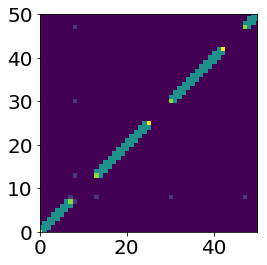

In [26]:
# re-make flat-powered transition matrix to account for new box cooridnates: [0,8], previously was [0,9]    
from scipy.sparse import diags
n = len(encode_settings.pos_bins)
transition_mat = np.zeros([n,n])
k = np.array([(1/3)*np.ones(n-1),(1/3)*np.ones(n),(1/3)*np.ones(n-1)])
offset = [-1,0,1]
transition_mat = diags(k,offset).toarray()
for x in encode_settings.arm_coordinates[:,0]:
    transition_mat[int(x),int(x)] = (5/9)
    transition_mat[8,int(x)] = (1/9)
    transition_mat[int(x),8] = (1/9)
for y in encode_settings.arm_coordinates[:,1]:
    transition_mat[int(y),int(y)] = (2/3)
transition_mat[8,0] = 0
transition_mat[0,8] = 0
transition_mat[8,8] = 0
transition_mat[0,0] = (2/3)
transition_mat[7,7] = (5/9)
transition_mat[7,8] = (1/9)
transition_mat[8,7] = (1/9)

        # uniform offset (gain, currently 0.0001)
        # needs to be set before running the encoder cell
        # normally: decode_settings.trans_uniform_gain
uniform_gain = 0.001
uniform_dist = np.ones(transition_mat.shape)*uniform_gain

        # apply uniform offset
transition_mat = transition_mat + uniform_dist

        # apply no animal boundary - make gaps between arms
transition_mat = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, transition_mat)

        # to smooth: take the transition matrix to a power
transition_mat = np.linalg.matrix_power(transition_mat,1)

        # apply no animal boundary - make gaps between arms
transition_mat = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, transition_mat)

        # normalize transition matrix
transition_mat = transition_mat/(transition_mat.sum(axis=0)[None, :])
transition_mat[np.isnan(transition_mat)] = 0

plt.imshow(transition_mat)
plt.xlim([0,50])
plt.ylim([0,50])

In [27]:
%%time
    #cell 15
    # Run PP decoding algorithm
    # NOTE 1-11-19 had to add spk_amp and vel to encode settings in order for decoding to run
    # what should these be set to? and why are they here now?
time_bin_size = 60
decode_settings = AttrDict({'trans_smooth_std': 2,
                                'trans_uniform_gain': 0.0001,
                                'time_bin_size':60})

encode_settings = AttrDict({'sampling_rate': 3e4,
                                'pos_bins': np.arange(0,max_pos,1), # arm_coords_wewant
                                'pos_bin_edges': np.arange(0,max_pos + .1,1), # edges_wewant, 
                                'pos_bin_delta': 1, 
                                # 'pos_kernel': sp.stats.norm.pdf(arm_coords_wewant, arm_coords_wewant[-1]/2, 1),
                                'pos_kernel': sp.stats.norm.pdf(np.arange(0,max_pos,1), max_pos/2, 0.2), #note that the pos_kernel mean should be half of the range of positions (ie 180/90) # sp.stats.norm.pdf(np.arange(0,560,1), 280, 1),    
                                'pos_kernel_std': 0.2, 
                                'mark_kernel_std': int(20), 
                                'pos_num_bins': max_pos, # len(arm_coords_wewant)
                                'pos_col_names': [pos_col_format(ii, max_pos) for ii in range(max_pos)], # [pos_col_format(int(ii), len(arm_coords_wewant)) for ii in arm_coords_wewant],
                                'arm_coordinates': np.array([[0,8],[13,25],[30,42],[47,59],[64,76],[81,93],[97,109],[114,125],[130,141]]), # arm_coordinates_WEWANT 'arm_coordinates': [[0,max_pos]]})
                                'spk_amp': 60,
                                'vel': 0})

    #when running the encoder and decoder at same time: trans_mat=encoder.trans_mat['flat_powered']
    #AND  prob_no_spike=encoder.prob_no_spike
    #when loading a previsouly generated observations table use: trans_mat=transition_matrix
    # AND prob_no_spike=probability_no_spike

print('Starting decoder')
# normally: trans_mat=encoder.trans_mat['flat_powered']
decoder = OfflinePPDecoder(observ_obj=observ_obj, trans_mat=transition_mat, 
                               prob_no_spike=encoder.prob_no_spike,
                               encode_settings=encode_settings, decode_settings=decode_settings, 
                               time_bin_size=time_bin_size, all_linear_position=pos_all_linear, velocity_filter=4)

posteriors = decoder.run_decoder()
print('Decoder finished!')
print('Posteriors shape: '+ str(posteriors.shape))
    

Starting decoder
decoder deleting
Beginning likelihood calculation
Beginning posterior calculation
Decoder finished!
Posteriors shape: (2052212, 144)
CPU times: user 9min 3s, sys: 6min 22s, total: 15min 25s
Wall time: 6min 9s


In [63]:
%%output size=100 backend='bokeh'
%%opts Curve [aspect=4] (color='black') 
# plot binning of data into 5cm bins -- (before randomizing trial order!)
p1 = hv.Curve(pos_all_linear['linpos_flat'],'time','linpos (cm)',group='orig')
p2 = hv.Curve(5*digitized,'time','binindex',group='digitized (x5 for scale)')
layout = hv.Layout(p1 +p2).cols(2)
layout

:Layout
   .Orig.I                                                      :Curve   [time]   (linpos (cm))
   .Digitized_left_parenthesis_x5_for_scale_right_parenthesis.I :Curve   [time]   (binindex)

In [107]:
%%output backend='bokeh' size=100
%%opts Histogram {+axiswise}
# plot postition histogram, marks histogrm, and rate
poshist, posbins = np.histogram(a=random_trial_pos_all_vel['linpos_flat'], bins=np.arange(0,145),normed=False)
hist1 = hv.Histogram(poshist,group='encode pos')
linflat_obj = random_trial_pos_all_vel.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(encode_spikes_random_trial_chron)
marks_linear = encode_spikes_random_trial_chron.assign(linear_pos=pd.Series(linflat_spkindex['linpos_flat']).values)
markshist, marksbins = np.histogram(a=marks_linear['linear_pos'], bins=np.arange(0, 145),normed=False)
hist2 = hv.Histogram(markshist,group='encode mark pos')
hist3 =hv.Histogram(markshist/poshist,group='FR')

layout = hv.Layout(hist1 + hist2+hist3).cols(3)
layout

:Layout
   .Encode_pos.I      :Histogram   [x]   (Frequency)
   .Encode_mark_pos.I :Histogram   [x]   (Frequency)
   .FR.I              :Histogram   [x]   (Frequency)

In [140]:
%%output backend='bokeh' size=100
%%opts Histogram {+axiswise}
# histograms to compare observations to posteriors 
hist_obs = []
obs_binsonly = observ_obj.drop(['elec_grp_id','position','dec_bin','dec_bin_start','num_missing_bins','parallel_bin'], axis=1)
#take axis label of max obs density, remove x prefix and cast as int to get binind
obs_maxbin = obs_binsonly.idxmax(axis=1).str.strip('x').astype(int) 
obshist,tmp = np.histogram(obs_maxbin,bins=np.arange(0,147))
h1 = hv.Histogram(obshist,group='max ind of observations')

lik_binsonly = decoder.likelihoods.drop(['num_spikes','dec_bin'], axis=1)
lik_maxbin = lik_binsonly.idxmax(axis=1).str.strip('x').astype(int)
lik_hist,tmp = np.histogram(lik_maxbin,bins=np.arange(0,147))
h2 = hv.Histogram(lik_hist,group='max ind of likelihoods')

post_binsonly = posteriors.drop(['num_spikes','dec_bin'], axis=1)
post_maxbin = post_binsonly.dropna().idxmax(axis=1).str.strip('x').astype(int)
post_hist,tmp = np.histogram(post_maxbin,bins=np.arange(0,147))
h3 = hv.Histogram(lik_hist,group='max ind of posteriors')
layout = hv.Layout(h1+h2+h3)
layout

:Layout
   .Max_ind_of_observations.I :Histogram   [x]   (Frequency)
   .Max_ind_of_likelihoods.I  :Histogram   [x]   (Frequency)
   .Max_ind_of_posteriors.I   :Histogram   [x]   (Frequency)

In [158]:
%%output backend='bokeh' size=100
%%opts Histogram
# plot the weird things that happen when you smooth firing rate with a .2sd kernel
enc_tet_lin_pos = random_trial_pos_all_vel.get_irregular_resampled(encode_spikes_random_trial_chron)
tetnum = 30
singletet = enc_tet_lin_pos.loc[(enc_tet_lin_pos.index.get_level_values('elec_grp_id') == tetnum)]
spikinghist,_ = np.histogram(singletet['linpos_flat'],bins = np.arange(0,147))
smhist = np.convolve(spikinghist, encode_settings.pos_kernel, mode='same')
p1 = hv.Histogram(spikinghist ,group='rawspike hist')

p1

:Histogram   [x]   (Frequency)

In [161]:
encode_settings['pos_kernel']


KeyError: 'pos_kernel'

(0, 80000)

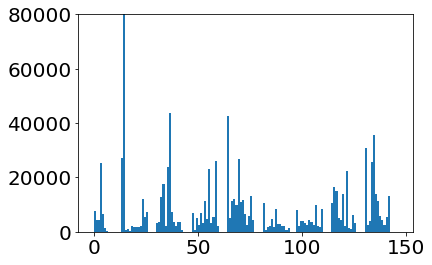

In [130]:
# shift is 0.4
plt.hist(obs_hist3,bins=np.arange(0,147))
plt.ylim([0,80000])

In [ ]:
    # to calculate histogram of posterior max position in each time bin

hist_bins = []
post_hist1 = decoder.likelihoods.drop(['num_spikes','dec_bin'], axis=1)
#post_hist1 = posteriors.drop(['num_spikes','dec_bin','ripple_grp'], axis=1)
post_hist2 = post_hist1.dropna()
post_hist3 = post_hist2.idxmax(axis=1)
post_hist3 = post_hist3.str.replace('x','')
post_hist3 = post_hist3.astype(int)
print(post_hist3.shape)
plt.hist(post_hist3,bins=np.arange(0,147))



In [30]:
    # to calculate histogram of posterior max position in each time bin

hist_bins = []
post_hist1 = posteriors.drop(['num_spikes','dec_bin'], axis=1)
#post_hist1 = posteriors.drop(['num_spikes','dec_bin','ripple_grp'], axis=1)
post_hist2 = post_hist1.dropna()
post_hist3 = post_hist2.idxmax(axis=1)
post_hist3 = post_hist3.str.replace('x','')
post_hist3 = post_hist3.astype(int)
print(post_hist3.shape)
hist_bins = np.histogram(post_hist3,bins=np.arange(0,147))
#print(post_hist3[10000:10001])
print(hist_bins)
unique, counts = np.unique(post_hist3, return_counts=True)
print(dict(zip(unique,counts)))

(1568910,)
(array([253541,  26443,  96204, 129254,  35696,  22223,   8319,   2554,
          115,      0,      0,      0,      0,  13318,  11865,   1629,
         1269,   1703,   1503,   1352,   1347,    968,   1614,   8891,
        19940,  69789,      0,      0,      0,      0,   3036,   2126,
         3373,   4721,   4709,   5369,   4825,   2853,   1537,   1138,
         3364,   5312,  33454,      0,      0,      0,      0,   6129,
         2346,   2114,   1217,   1265,   1640,   1828,   1723,   3196,
         4072,   8756,  25322, 118445,      0,      0,      0,      0,
        19458,   6634,   5620,   8435,  13508,  12229,   7966,   6023,
         3578,   1851,   3246,   8797,  57985,      0,      0,      0,
            0,   9570,   2604,   1359,   2311,   4657,   4284,   8599,
        10222,   8182,   8105,   6080,  16023,  51193,      0,      0,
            0,   5365,   1486,   1243,   1548,   1931,   2026,   1545,
         2276,   2848,   1728,   2340,   3649,  16635,      0,   

(0, 150000)

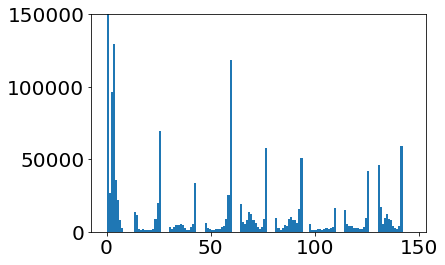

In [35]:
plt.hist(post_hist3,bins=np.arange(0,147))
plt.ylim([0,150000])

In [233]:
# save posteriors and position
posterior_file_name = '/data2/mcoulter/remy/' + rat_name + '_' + str(day_dictionary[rat_name][0]) + '_' + str(epoch_dictionary[rat_name][0]) + '_vel4_position_bins_mask_convol_new_pos_yes_random_marks_shuffle_' + str(marks_index_shift) + '_posteriors_6_4_19.nc'

post1 = posteriors.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
post2 = post1.reset_index()
post3 = convert_dan_posterior_to_xarray(post2, tetrodes_dictionary[rat_name], velocity_filter, encode_settings, decode_settings, encoder.trans_mat['flat_powered'], offset_30Hz_time_bins, trialsindex_shuffled, marks_index_shift)
    #print(len(post3))
post3.to_netcdf(posterior_file_name)
print('Saved posteriors to '+posterior_file_name)

    # to export linearized position to MatLab: again convert to xarray and then save as netcdf

position_file_name = '/data2/mcoulter/remy/' + rat_name + '_' + str(day_dictionary[rat_name][0]) + '_' + str(epoch_dictionary[rat_name][0]) + '_vel4_position_bins_mask_convol_new_pos_yes_random_marks_shuffle_' + str(marks_index_shift) + '_linearposition_6_4_19.nc'

linearized_pos1 = pos_all_linear.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
linearized_pos2 = linearized_pos1.reset_index()
linearized_pos3 = linearized_pos2.to_xarray()
linearized_pos3.to_netcdf(position_file_name)
print('Saved linearized position to '+position_file_name)
    

/home/mcoulter/anaconda3/lib/python3.6/site-packages/dask/utils.py:1014: UserWarning:
Deprecated, see dask.base.get_scheduler instead


Saved posteriors to /data2/mcoulter/remy/remy_20_2_vel4_position_bins_mask_convol_new_pos_yes_random_marks_shuffle_194238_posteriors_6_4_19.nc
Saved linearized position to /data2/mcoulter/remy/remy_20_2_vel4_position_bins_mask_convol_new_pos_yes_random_marks_shuffle_194238_linearposition_6_4_19.nc


/home/mcoulter/anaconda3/lib/python3.6/site-packages/dask/utils.py:1014: UserWarning:
Deprecated, see dask.base.get_scheduler instead


(0, 150000)

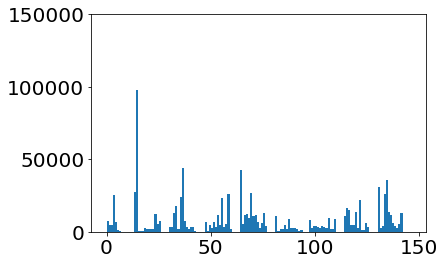

In [36]:
plt.hist(obs_hist3,bins=np.arange(0,147))
plt.ylim([0,150000])
#plt.xlim([0,50])

In [49]:
#prob_no_spike across all tetrodes
whole_prob_no_spike = np.prod(list(encoder.prob_no_spike.values()), axis=0)

(0, 2)

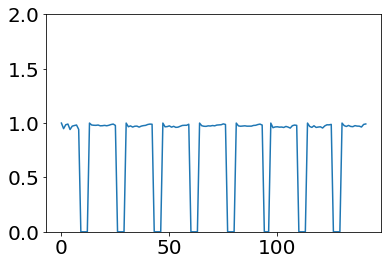

In [52]:
plt.plot(whole_prob_no_spike)
plt.ylim([0,2])

(0, 0.05)

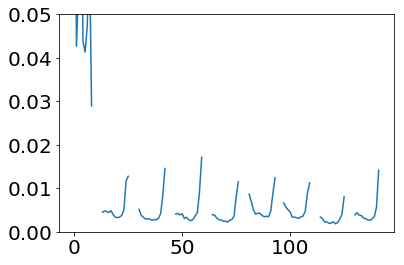

In [292]:
plt.plot(encoder.occupancy)
#plt.xlim([0,50])
plt.ylim([0,0.05])

(0, 50)

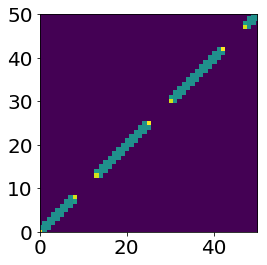

In [260]:
plt.imshow(encoder.trans_mat['flat_powered'])
plt.xlim([0,50])
plt.ylim([0,50])

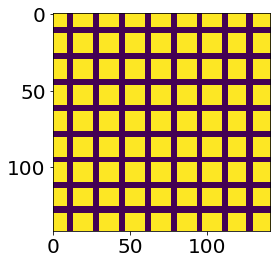

In [313]:
plt.imshow(np.linalg.matrix_power(transition_mat, 150))

In [28]:
%%output backend='bokeh' size=400 holomap='scrubber'
%%opts RGB { +framewise} [height=100 width=250 aspect=2 colorbar=True]
%%opts Points [height=100 width=250 aspect=2 ] (marker='o' color='#AAAAFF' size=1 alpha=0.7)
%%opts Polygons (color='grey', alpha=0.5 fill_color='grey' fill_alpha=0.5)
#%%opts Image {+framewise}

# visualize posteriors - note will only work a small chunck of the posteriors table

dec_viz = DecodeVisualizer(posteriors[0:200000], linpos=pos_all_linear.loc[(pos_all_linear["linvel_flat"]>4)], riptimes=rips_vel_filtered[50:100], enc_settings=encode_settings)

dec_viz.plot_all_dynamic(stream=hv.streams.RangeXY(), plt_range=100, slide=10)


AttributeError: module 'holoviews' has no attribute 'streams'

In [ ]:
#pos histogram for linearized position
#plt.plot(pos_all_linear['linpos_flat'][100000:1220000].values)
# velocity filter
pos_all_linear_vel = pos_all_linear.loc[(pos_all_linear["linvel_flat"]>4)]
pos_linear_hist = plt.hist(pos_all_linear_vel['linpos_flat'],bins=np.arange(0,147))
plt.ylim([0,1000])
#plt.colorbar()
pos_all_linear_vel.shape

# pos data with random arm shift
arm_swap_trial_pos_all_vel = arm_swap_trial_pos_all.loc[(arm_swap_trial_pos_all['linvel_flat']>4)]
pos_linear_hist_swap = plt.hist(arm_swap_trial_pos_all_vel['linpos_flat'],np.arange(0,147), alpha=0.5)
#arm_swap_trial_pos_all_vel.shape

In [ ]:
pos_linear_hist

In [ ]:
#marks histogram for linearized position
pos_all_linear_vel = pos_all_linear.loc[(pos_all_linear["linvel_flat"]>4)]

linflat_obj_vel = pos_all_linear.get_mapped_single_axis()
linflat_spkindex_vel = linflat_obj_vel.get_irregular_resampled(marks)
linflat_spkindex_encode_velthresh = linflat_spkindex_vel.query('linvel_flat > 4')

marks_vel = marks.loc[linflat_spkindex_encode_velthresh.index]
marks_vel.shape

import matplotlib.colors as mcolors
#marks
linflat_obj = pos_all_linear_vel.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(marks_vel)
linflat_spkindex

marks_linear = marks_vel.assign(linear_pos=pd.Series(linflat_spkindex['linpos_flat']).values)
marks_linear
#plt.hist(marks_linear['linear_pos'],bins=147)
marks_hist = plt.hist(marks_linear['linear_pos'],bins=np.arange(0,147))
plt.ylim
#plt.hist2d(marksXY['posX'],marksXY['posY'],bins=50,weights=marksXY['mark'],cmin=0,cmax=8000)
#plt.hist2d(marksXY['posX'],marksXY['posY'],bins=50,cmin=0,cmax=8000)
#plt.colorbar()

marks_linear.shape

0 below -999uV events removed
original length: 10597
after non-negative filtering: 10597
0 above 2000uV events removed
0 below 100uV events removed
original length: 10597
after filtering: 10597


Text(0.5,1,'Encoding marks for each tetrode')

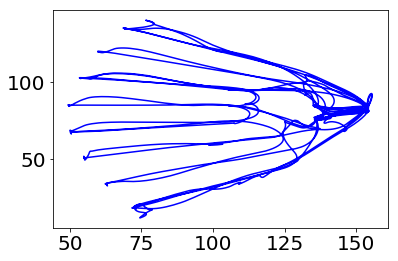

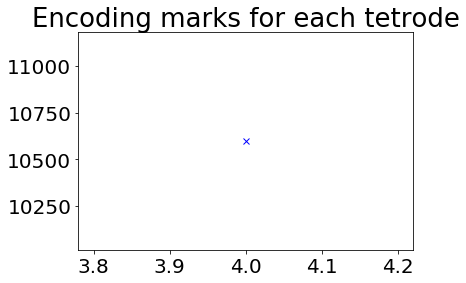

In [8]:
# Encoding input data, position and spikes
# **** time is 30x sec
# total length of pos is 122,000 this is 4,000 seconds or 1hr
subset_start = 0
subset_end = 11000
#subset_start = 120150
#subset_end = 120200
chunkstart = pos.index.get_level_values('time')[subset_start]
chunkend = pos.index.get_level_values('time')[subset_end]
speed_threshold_save = 0; 

# Define path base - moved to linearization cell
#path_base_timewindow = str(int(round(chunkstart))) + 'to' + str(int(round(chunkend))) + 'sec'
#path_base_foranalysisofonesessionepoch = path_base_analysis + rat_name + '/' + path_base_dayepoch + '/' + path_base_timewindow

pos_subset = pos.loc[(pos.index.get_level_values('time') <= chunkend) & (pos.index.get_level_values('time') >= chunkstart)]
posY_subset = posY.loc[(posY.index.get_level_values('time') <= chunkend) & (posY.index.get_level_values('time') >= chunkstart)] 
pos_start= pos_subset.index.get_level_values('time')[0]
pos_end = pos_subset.index.get_level_values('time')[-1]
spk_subset = marks.loc[(marks.index.get_level_values('time') <  pos_end) & (marks.index.get_level_values('time') >  pos_start)]
#rip_subset = rips.loc[(rips['starttime'].values >  pos_start) & (rips['endtime'].values <  pos_end)]
#rip_subset = rips_vel_filtered.loc[(rips_vel_filtered['starttime'].values >  pos_start) & (rips_vel_filtered['endtime'].values <  pos_end)]

#whole epoch
#spk_subset = marks
#rip_subset = rips_vel_filtered

spk_subset_non_negative = trodes2SS.threshold_marks_negative(spk_subset, negthresh=-999)
print('original length: '+str(spk_subset.shape[0]))
print('after non-negative filtering: '+str(spk_subset_non_negative.shape[0]))

spk_subset_sparse = trodes2SS.threshold_marks(spk_subset_non_negative, maxthresh=2000,minthresh=100)
print('original length: '+str(spk_subset_non_negative.shape[0]))
print('after filtering: '+str(spk_subset_sparse.shape[0]))

spk_subset_sparse.groupby('elec_grp_id')

plt.plot(pos_subset['linpos_flat'].values,posY_subset['linpos_flat'].values,'b')

# Plot marks for each tetrode 
plt.figure()
plt.plot(tetrodes_dictionary[rat_name],spk_subset_sparse.groupby('elec_grp_id').count().values[:,0],'bx')
plt.title('Encoding marks for each tetrode')

In [ ]:
#marks for random arm shift positions
arm_swap_trial_pos_all_vel = arm_swap_trial_pos_all.loc[(arm_swap_trial_pos_all["linvel_flat"]>4)]

linflat_obj_vel = arm_swap_trial_pos_all.get_mapped_single_axis()
linflat_spkindex_vel = linflat_obj_vel.get_irregular_resampled(marks)
linflat_spkindex_encode_velthresh = linflat_spkindex_vel.query('linvel_flat > 4')

marks_vel = marks.loc[linflat_spkindex_encode_velthresh.index]
marks_vel.shape

import matplotlib.colors as mcolors
#marks
linflat_obj = arm_swap_trial_pos_all_vel.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(marks_vel)
linflat_spkindex

marks_linear = marks_vel.assign(linear_pos=pd.Series(linflat_spkindex['linpos_flat']).values)
marks_linear
plt.hist(marks_linear['linear_pos'],bins=142)
#plt.hist2d(marksXY['posX'],marksXY['posY'],bins=50,weights=marksXY['mark'],cmin=0,cmax=8000)
#plt.hist2d(marksXY['posX'],marksXY['posY'],bins=50,cmin=0,cmax=8000)
#plt.colorbar()

marks_linear.shape

In [ ]:
#firing rate for linearized position
pos_linear_hist = plt.hist(arm_swap_trial_pos_all_vel['linpos_flat'],bins=142)
marks_linear_hist = plt.hist(marks_linear['linear_pos'],bins=142)
pos_all_linear_vel.shape

In [ ]:
#firing rate for linearied position
plt.rcParams['figure.figsize'] = [12,7]
plt.bar(np.arange(len(marks_linear_hist[0])),marks_linear_hist[0]/(pos_linear_hist[0]/30))
#plt.colorbar()
#np.arange(len(marks_linear_hist[0]))

In [359]:
#firing rate summary stats by arm
# NOTE: these arm cooridnates were changed for the randomized arm order, need to change back if looking at normal data
# for normal data - you can basically just use the values from arm coordinates we want

firing_rate = marks_linear_hist[0]/(pos_linear_hist[0]/30)
np.mean(firing_rate[12:25])
print('box: ',np.mean(firing_rate[0:9]))
print('arm 1: ',np.mean(firing_rate[13:26]))
print('arm 2: ',np.mean(firing_rate[29:42]))
print('arm 3: ',np.mean(firing_rate[46:59]))
print('arm 4: ',np.mean(firing_rate[63:76]))
print('arm 5: ',np.mean(firing_rate[80:93]))
print('arm 6: ',np.mean(firing_rate[96:110]))
print('arm 7: ',np.mean(firing_rate[113:125]))
print('arm 8: ',np.mean(firing_rate[129:142]))

#pos_linear_hist[0][128:142]
#firing_rate[12:27]


box:  1313.6631545200019
arm 1:  1242.5185921650814
arm 2:  1276.1682135921048
arm 3:  1216.3277162460363
arm 4:  1248.7720863077138
arm 5:  1180.5077105941864
arm 6:  1206.5671102785818
arm 7:  1260.1165480546053
arm 8:  1248.2603865154078


In [242]:
# save histograms as csv
#pos_hist_pandas = pd.DataFrame(data=pos_hist[0],index=np.arange(0,50),columns=np.arange(0,50))
#pos_hist_pandas.to_csv('/data2/mcoulter/position_hist_2msec_5_14_19.csv')

#marks_hist_pandas = pd.DataFrame(data=marks_hist[0],index=np.arange(0,50),columns=np.arange(0,50))
#marks_hist_pandas.to_csv('/data2/mcoulter/marks_hist_2msec_5_14_19.csv')

firing_rate_all = marks_hist[0]/pos_hist[0]
firing_rate_all_pandas = pd.DataFrame(data=firing_rate_all,index=np.arange(0,50),columns=np.arange(0,50))
firing_rate_all_pandas.to_csv('/data2/mcoulter/firing_rate_all_2msec_5_14_19.csv')

In [32]:
# test negative marks filter
# this should get rid of 1 mark (this was after velocity filter)
# when run on whole dataset gets rids of 23, that seems fine
# remy: 0
# bernard: 70
# fievel: 0
spk_subset_non_negative = trodes2SS.threshold_marks_negative(marks, negthresh=-999)
print('original length: '+str(marks.shape[0]))
print('after non-negative filtering: '+str(spk_subset_non_negative.shape[0]))

0 below -999uV events removed
original length: 2215307
after non-negative filtering: 2215307


(10001, 2)

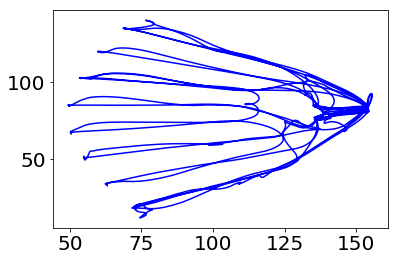

In [126]:
subset_start = 0
subset_end = 10000
#subset_start = 7400
#subset_end = 7401
#subset_start = 120075
#subset_end = 120200
chunkstart = pos.index.get_level_values('time')[subset_start]
chunkend = pos.index.get_level_values('time')[subset_end]
speed_threshold_save = 0; 

# Define path base - moved to linearization cell
#path_base_timewindow = str(int(round(chunkstart))) + 'to' + str(int(round(chunkend))) + 'sec'
#path_base_foranalysisofonesessionepoch = path_base_analysis + rat_name + '/' + path_base_dayepoch + '/' + path_base_timewindow

pos_2d_subset = pos.loc[(pos.index.get_level_values('time') <= chunkend) & (pos.index.get_level_values('time') >= chunkstart)]
posY_2d_subset = posY.loc[(posY.index.get_level_values('time') <= chunkend) & (posY.index.get_level_values('time') >= chunkstart)] 
pos_start= pos_subset.index.get_level_values('time')[0]
pos_end = pos_subset.index.get_level_values('time')[-1]
spk_subset = marks.loc[(marks.index.get_level_values('time') <  pos_end) & (marks.index.get_level_values('time') >  pos_start)]

spk_subset_sparse.groupby('elec_grp_id')

plt.plot(pos_2d_subset['linpos_flat'].values,posY_2d_subset['linpos_flat'].values,'b')
pos_subset.shape


(10001,)
(10001, 2)


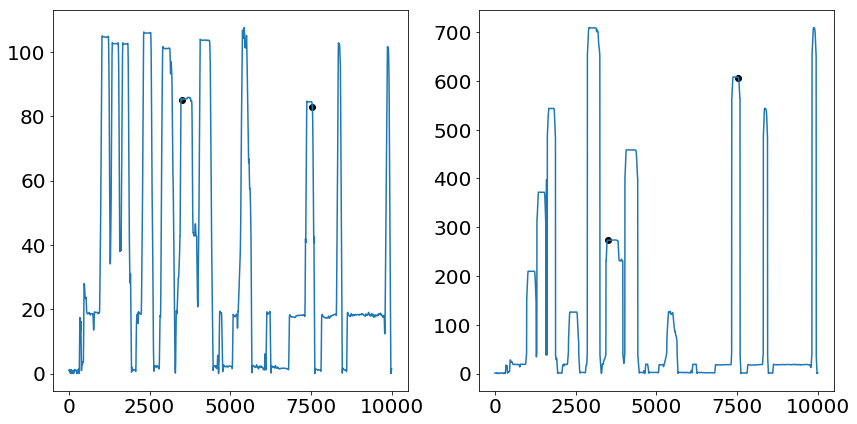

In [170]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
print(track_segment_id.shape)
print(pos_subset.shape)
pos_subset
#plt.plot(linear_distance_arm_shift[7500:7510])
#plt.ylim(550,610)
pos_subset.shape
linear_distance_arm_shift.shape
axes[0].plot(linear_distance)
axes[0].scatter(np.arange(1) + 7544, linear_distance[7544:7545],color='black')
axes[0].scatter(np.arange(1) + 3500, linear_distance[3500:3501],color='black')
axes[1].plot(linear_distance_arm_shift)
axes[1].scatter(np.arange(1) + 7544, linear_distance_arm_shift[7544:7545],color='black')
axes[1].scatter(np.arange(1) + 3500, linear_distance_arm_shift[3500:3501],color='black')

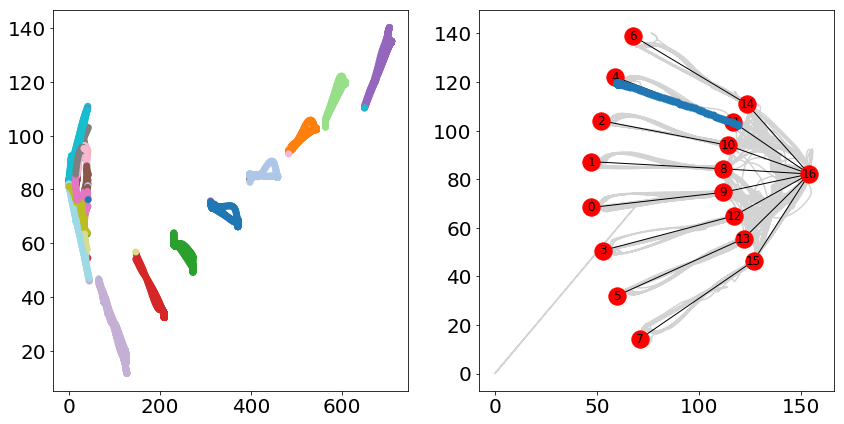

In [82]:
from loren_frank_data_processing.track_segment_classification import plot_track

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[1].plot(pos, posY, color='lightgrey', zorder=0)
plot_track(track_graph, ax=axes[1])
plt.scatter(pos_7_subset['linpos_flat'].values,posY_7_subset['linpos_flat'].values,s=50, zorder=100)

axes[0].scatter(pos_subset['linpos_flat'], posY_subset['linpos_flat'], c=track_segment_id,
                cmap='tab20')

(0, 40)

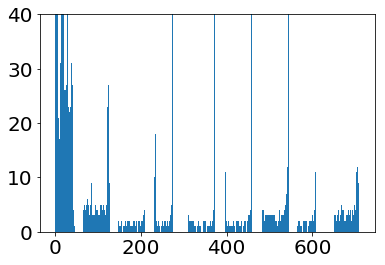

In [153]:
plt.hist(linear_distance_arm_shift,710)
plt.ylim(0,40)

In [5]:
# velocity filter for encoding spikes
# note old cells for velocity filter are in "Jens_latest..." notebook

#linflat_obj = pos_subset.get_mapped_single_axis()
linflat_obj = pos.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(spk_subset_sparse)
linflat_spkindex_encode_velthresh = linflat_spkindex.query('linvel_flat > 2')

spk_subset_sparse_encode = spk_subset_sparse.loc[linflat_spkindex_encode_velthresh.index]

print('encoding spikes after filtering: '+str(spk_subset_sparse_encode.shape[0]))

encoding spikes after filtering: 166241


0 above 2000uV events removed
0 below 100uV events removed
original length: 301800
after filtering: 301800


Text(0.5,1,'Decoding marks for each tetrode')

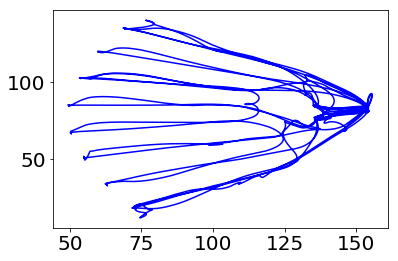

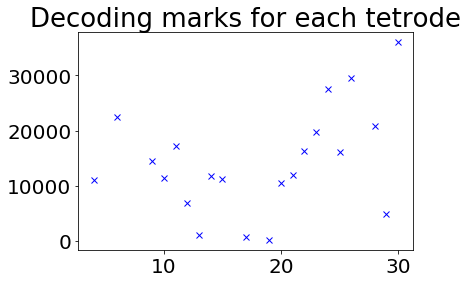

In [6]:
# Decoding input data, position and spikes
# **** time is 30x sec
chunkstart_decode = pos.index.get_level_values('time')[0]
chunkend_decode = pos.index.get_level_values('time')[10000]
speed_threshold_save = 0; 

pos_subset_decode = pos.loc[(pos.index.get_level_values('time') <= chunkend_decode) & (pos.index.get_level_values('time') >= chunkstart_decode)]
posY_subset_decode = posY.loc[(posY.index.get_level_values('time') <= chunkend_decode) & (posY.index.get_level_values('time') >= chunkstart_decode)] 
pos_start_decode = pos_subset_decode.index.get_level_values('time')[0]
pos_end_decode = pos_subset_decode.index.get_level_values('time')[-1]
spk_subset_decode = marks.loc[(marks.index.get_level_values('time') <  pos_end_decode) & (marks.index.get_level_values('time') >  pos_start_decode)]
#rip_subset_decode = rips.loc[(rips['starttime'].values >  pos_start) & (rips['endtime'].values <  pos_end)]
rip_subset_decode = rips_vel_filtered.loc[(rips_vel_filtered['starttime'].values > pos_start_decode) & (rips_vel_filtered['endtime'].values <  pos_end_decode)]

#whole epoch
#spk_subset_decode = marks
#rip_subset_decode = rips_vel_filtered

spk_subset_sparse_decode = trodes2SS.threshold_marks(spk_subset_decode, maxthresh=2000,minthresh=100)
print('original length: '+str(spk_subset_decode.shape[0]))
print('after filtering: '+str(spk_subset_sparse_decode.shape[0]))

spk_subset_sparse_decode.groupby('elec_grp_id')

#plt.rcParams["figure.figsize"] = [12,9]
plt.plot(pos_subset_decode['linpos_flat'].values,posY_subset_decode['linpos_flat'].values,'b')

# Plot marks for each tetrode 
plt.figure()
plt.plot(tetrodes_dictionary[rat_name],spk_subset_sparse_decode.groupby('elec_grp_id').count().values[:,0],'bx')
plt.title('Decoding marks for each tetrode')

In [7]:
#velocity filter for decoding spikes
linflat_obj = pos_subset.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(spk_subset_sparse_decode)
linflat_spkindex_decode_velthresh = linflat_spkindex.query('linvel_flat < 2')

spk_subset_sparse_decode_filt = spk_subset_sparse_decode.loc[linflat_spkindex_decode_velthresh.index]

print('decoding spikes after filtering: '+str(spk_subset_sparse_decode_filt.shape[0]))

decoding spikes after filtering: 135559


In [ ]:
pos_subset_linear

In [8]:
# linearize a subset - should only have to do this once.
linear_start = pos.index.get_level_values('time')[subset_start]
linear_end = pos.index.get_level_values('time')[subset_end]

# Define path base
path_base_timewindow = str(int(round(linear_start))) + 'to' + str(int(round(linear_end))) + 'sec'
path_base_foranalysisofonesessionepoch = path_base_analysis + rat_name + '/' + path_base_dayepoch + '/' + path_base_timewindow

# Change to directory with saved linearization result
# Define folder for saved linearization result 
linearization_output_save_path = path_base_foranalysisofonesessionepoch + '/linearization_output/'
linearization_output_save_path
# Check if it exists, make if it doesn't
directory_path = linearization_output_save_path
change_to_directory_make_if_nonexistent(directory_path)

# Define name of linearization result
linearization_output1_save_filename = 'linearization_' + path_base_timewindow + '_speed' + str(speed_threshold_save) + '_linear_distance_arm_shift' + '.npy'
linearization_output2_save_filename = 'linearization_' + path_base_timewindow + '_speed' + str(speed_threshold_save) + '_track_segment_id_use' + '.npy'
# If linearization result doesn't exist, do linearization calculation
if os.path.exists(linearization_output1_save_filename) == False:
    print('Linearization result doesnt exist. Doing linearization calculation')

    # Prepare for linearization 
    
    # Create graph elements
    track_graph, track_segments, center_well_id = createTrackGraph(maze_coordinates)
    #track_segments = lfdp.track_segment_classification.get_track_segments_from_graph(track_graph)

    # Define shift amounts 
    # 1-13-19 trying 10cm bins with flat transition matrix, set hardcode_shiftamount to 20
    # **** 
    hardcode_armorder = hack_determinearmorder(track_segments) # add progressive stagger in this order
    hardcode_shiftamount = 20 # add this stagger to sum of previous shifts
    # ****
    linearization_arm_lengths = []
    # Caculate length of outer arms, plot
    for track_segment in enumerate(track_segments): # for each track segment
        plt.plot(track_segment[1][:,0],track_segment[1][:,1]) # plot track segment
        plt.text(track_segment[1][0,0],track_segment[1][0,1],str(track_segment[0])) # label with segment number
        # Calculate and plot length of outer arms 
        if track_segment[0] < 8: # if an outer arm, calculate length 
            linearization_arm_lengths.append(np.linalg.norm(track_segment[1][0,:] - track_segment[1][1,:])) # calculate length
            plt.text(track_segment[1][0,0],track_segment[1][0,1] - 4,str(linearization_arm_lengths[track_segment[0]])) # text to show length 
    # Define dictionary for shifts for each arm segment
    shift_linear_distance_by_arm_dictionary = dict() # initialize empty dictionary 
    for arm in enumerate(hardcode_armorder): # for each outer arm
        if arm[0] == 0: # if first arm, just shift hardcode_shiftamount
            temporary_variable_shift = hardcode_shiftamount 
        else: # if not first arm, add to hardcode_shiftamount length of previous arm 
            temporary_variable_shift = hardcode_shiftamount + linearization_arm_lengths[arm[0]] + shift_linear_distance_by_arm_dictionary[hardcode_armorder[arm[0] - 1]]
        shift_linear_distance_by_arm_dictionary[arm[1]] = temporary_variable_shift
    # Plot 
    plt.figure()
    for track_segment in enumerate(track_segments):
        plt.plot(track_segment[1][:,0],track_segment[1][:,1])
        plt.text(track_segment[1][0,0],track_segment[1][0,1],str(track_segment[0]))
        # Calculate and plot length of outer arms 
        if track_segment[0] < 8: # if an outer arm, calculate length 
            plt.text(track_segment[1][0,0],track_segment[1][0,1] - 4,str(shift_linear_distance_by_arm_dictionary[track_segment[0]]))
        plt.title('large numbers go into linear distance dictionary')
        
    
    # Pull node coordinates (store as node_coords)
    temp2 = [] # list for node coordinates
    for eachnode in track_graph.nodes: # for each node
        temp = list(track_graph.nodes[eachnode]['pos'])
        temp2.append(temp)
    node_coords = np.asarray(temp2)
    # Assign nodes to track segments
    track_segment_id_nodes = lfdp.track_segment_classification.find_nearest_segment(track_segments, node_coords)

    # Calculate linear distance of nodes to back well 
    linear_distance_nodes = lfdp.track_segment_classification.calculate_linear_distance(
            track_graph, track_segment_id_nodes, center_well_id, node_coords)

    # Linearize position
    pos_subset_linear = pos.loc[(pos.index.get_level_values('time') <= linear_end) & (pos.index.get_level_values('time') >= linear_start)]
    posY_subset_linear = posY.loc[(posY.index.get_level_values('time') <= linear_end) & (posY.index.get_level_values('time') >= linear_start)] 

    # Vector with position
    simplepos = np.vstack([pos_subset_linear['linpos_flat'],posY_subset_linear['linpos_flat']]) # x pos, y pos
    # Store under different name to plot for debugging 
    simplepos_original = simplepos 

    # Assign each position to a track segment
    # ****
    sensor_std_dev = 1 # 10
    assign_track_segments_one_is_Markov_two_is_naive = 2 # 1 for hidden markov model, 2 for naive
    # ****
    # Define back well
    #center_well_id = 17
    center_well_id = 16
    # HIDDEN MARKOV MODEL:
    # Assign position to track segment
    track_segment_id = lfdp.track_segment_classification.classify_track_segments(track_graph,
                                simplepos.T, sensor_std_dev=sensor_std_dev, route_euclidean_distance_scaling=1)
    # SIMPLER WAY: 
    #track_segments = lfdp.track_segment_classification.get_track_segments_from_graph(track_graph)
    track_segment_id_naive = lfdp.track_segment_classification.find_nearest_segment(track_segments, simplepos.T)
    # Choose track segment assignment 
    if assign_track_segments_one_is_Markov_two_is_naive == 1:
        track_segment_id_use = track_segment_id
    elif assign_track_segments_one_is_Markov_two_is_naive == 2:   
        track_segment_id_use = track_segment_id_naive
    # Find linear distance of position from back well 
    linear_distance = lfdp.track_segment_classification.calculate_linear_distance(track_graph, 
                                 track_segment_id_use, center_well_id, simplepos.T)

    # Modify: 1) collapse non-arm locations, 2) shift linear distance for the 8 arms
    newseg = np.copy(track_segment_id_use)
    # 1) Collapse non-arm locations
    # newseg[(newseg < 16) & (newseg > 7)] = 8
    # newseg[(newseg == 16)] = 9
    #try making one segment for box
    newseg[(newseg < 17) & (newseg > 7)] = 8
    
    # 2) Shift linear distance for each arm 
    linear_distance_arm_shift = np.copy(linear_distance)
    for seg in shift_linear_distance_by_arm_dictionary:
        linear_distance_arm_shift[(newseg==seg)]+=shift_linear_distance_by_arm_dictionary[seg]  
    # Incorporate modifications 
    plt.figure()
    plt.plot(linear_distance_arm_shift)
    # problem: this pos_subset is next used by the encoder, but now it doesnt match the subset of time for spikes
    # this like is still causing problems, becuase we can plot the position during the decoded time...
    # what is this line doing?
    # okay so we need to linearize the whole eopch and then look-up the encoding time
    # we should be able to use the same indecies eg 5000 - 11000
    pos_subset['linpos_flat']=linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]
    #pos_subset_decode is only required for visualization
    #pos_subset_decode['linpos_flat'] = linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]

    # Store some linearization results in python format for quick loading (pos_subset) 
    np.save(linearization_output1_save_filename, linear_distance_arm_shift)
    np.save(linearization_output2_save_filename, track_segment_id_use)
    
    
    
    # Save some linearization results in .mat file
    # Convert dictionary with shift for each arm to array since matlab can't read the dictionary 
    linearization_shift_segments_list = []
    for key in shift_linear_distance_by_arm_dictionary:
        temp = [key,shift_linear_distance_by_arm_dictionary[key]]
        linearization_shift_segments_list.append(temp)    
    # Change directory
    change_to_directory_make_if_nonexistent(linearization_output_save_path)
    # Define file name 
    file_name_temp = [rat_name + '_day' + str(day_dictionary[rat_name][0]) + '_epoch' + str(epoch_dictionary[rat_name][0]) + 
                      '_' + path_base_timewindow +
                      '_speed' + str(speed_threshold_save) + 
                      '_linearization_variables.mat']    

    # Store variables 
    export_this = AttrDict({'linearization_segments': track_segments,
                            'linearization_nodes_coordinates': node_coords,
                            'linearization_nodes_distance_to_back_well':linear_distance_nodes,
                            'linearization_shift_segments_list': linearization_shift_segments_list,
                            'linearization_position_segments':track_segment_id_use,
                            'linearization_position_distance_from_back_well':linear_distance,
                            'linearization_position_distance_from_back_well_arm_shift':linear_distance_arm_shift
                           })
    # Warn before overwriting file 
    if os.path.exists(file_name_temp[0]) == True:
        input("Press Enter to overwrite file")
        print('overwriting')
    # Save 
    print('saving file:',file_name_temp)
    sio.savemat(file_name_temp[0],export_this)
    
    

# If linearization result exists, load it 
else:
    print('Linearization result exists. Loading it.')
    linear_distance_arm_shift = np.load(linearization_output1_save_filename)
    #test = np.load(linearization_output3_save_filename)
    track_segment_id_use = np.load(linearization_output2_save_filename)
    pos_subset['linpos_flat'] = linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]
    #for whole epoch when using -1
    #pos_subset['linpos_flat'] = linear_distance_arm_shift[(subset_start):(subset_end)]
    #pos_subset_decode['linpos_flat'] = linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]
    

Linearization result exists. Loading it.


In [5]:
%%time
# linearize the whole epoch - this gets rid of the pos_subset variables and linearizes position of whole epoch

encode_settings = AttrDict({'arm_coordinates': [[0,0]]})
# variables for all position data
pos_all_linear = datasrc.import_pos(encode_settings, xy='x')
posY1 = datasrc.import_pos(encode_settings, xy='y')
speed_threshold_save = 0;

#linear_start = pos.index.get_level_values('time')[subset_start]
#linear_end = pos.index.get_level_values('time')[subset_end]

# Define path base
#path_base_timewindow = str(int(round(linear_start))) + 'to' + str(int(round(linear_end))) + 'sec'
path_base_timewindow = 'whole_epoch_v3'
path_base_foranalysisofonesessionepoch = path_base_analysis + rat_name + '/' + path_base_dayepoch + '/' + path_base_timewindow

# Change to directory with saved linearization result
# Define folder for saved linearization result 
linearization_output_save_path = path_base_foranalysisofonesessionepoch + '/linearization_output/'
linearization_output_save_path
# Check if it exists, make if it doesn't
directory_path = linearization_output_save_path
change_to_directory_make_if_nonexistent(directory_path)

# Define name of linearization result
linearization_output1_save_filename = 'linearization_' + path_base_timewindow + '_speed' + str(speed_threshold_save) + '_linear_distance_arm_shift' + '.npy'
linearization_output2_save_filename = 'linearization_' + path_base_timewindow + '_speed' + str(speed_threshold_save) + '_track_segment_id_use' + '.npy'
# If linearization result doesn't exist, do linearization calculation
if os.path.exists(linearization_output1_save_filename) == False:
    print('Linearization result doesnt exist. Doing linearization calculation')

    # Prepare for linearization 
    
    # Create graph elements
    track_graph, track_segments, center_well_id = createTrackGraph(maze_coordinates)
    #track_segments = lfdp.track_segment_classification.get_track_segments_from_graph(track_graph)

    # Define shift amounts 
    # 1-13-19 trying 10cm bins with flat transition matrix, set hardcode_shiftamount to 20
    # **** 
    hardcode_armorder = hack_determinearmorder(track_segments) # add progressive stagger in this order
    hardcode_shiftamount = 20 # add this stagger to sum of previous shifts
    # ****
    linearization_arm_lengths = []
    # Caculate length of outer arms, plot
    for track_segment in enumerate(track_segments): # for each track segment
        plt.plot(track_segment[1][:,0],track_segment[1][:,1]) # plot track segment
        plt.text(track_segment[1][0,0],track_segment[1][0,1],str(track_segment[0])) # label with segment number
        # Calculate and plot length of outer arms 
        if track_segment[0] < 8: # if an outer arm, calculate length 
            linearization_arm_lengths.append(np.linalg.norm(track_segment[1][0,:] - track_segment[1][1,:])) # calculate length
            plt.text(track_segment[1][0,0],track_segment[1][0,1] - 4,str(linearization_arm_lengths[track_segment[0]])) # text to show length 
    # Define dictionary for shifts for each arm segment
    shift_linear_distance_by_arm_dictionary = dict() # initialize empty dictionary 
    for arm in enumerate(hardcode_armorder): # for each outer arm
        if arm[0] == 0: # if first arm, just shift hardcode_shiftamount
            temporary_variable_shift = hardcode_shiftamount 
        else: # if not first arm, add to hardcode_shiftamount length of previous arm 
            temporary_variable_shift = hardcode_shiftamount + linearization_arm_lengths[arm[0]] + shift_linear_distance_by_arm_dictionary[hardcode_armorder[arm[0] - 1]]
        shift_linear_distance_by_arm_dictionary[arm[1]] = temporary_variable_shift
    # Plot 
    plt.figure()
    for track_segment in enumerate(track_segments):
        plt.plot(track_segment[1][:,0],track_segment[1][:,1])
        plt.text(track_segment[1][0,0],track_segment[1][0,1],str(track_segment[0]))
        # Calculate and plot length of outer arms 
        if track_segment[0] < 8: # if an outer arm, calculate length 
            plt.text(track_segment[1][0,0],track_segment[1][0,1] - 4,str(shift_linear_distance_by_arm_dictionary[track_segment[0]]))
        plt.title('large numbers go into linear distance dictionary')
        
    
    # Pull node coordinates (store as node_coords)
    temp2 = [] # list for node coordinates
    for eachnode in track_graph.nodes: # for each node
        temp = list(track_graph.nodes[eachnode]['pos'])
        temp2.append(temp)
    node_coords = np.asarray(temp2)
    # Assign nodes to track segments
    track_segment_id_nodes = lfdp.track_segment_classification.find_nearest_segment(track_segments, node_coords)

    # Calculate linear distance of nodes to back well 
    linear_distance_nodes = lfdp.track_segment_classification.calculate_linear_distance(
            track_graph, track_segment_id_nodes, center_well_id, node_coords)

    # Linearize position
    #pos_subset_linear = pos.loc[(pos.index.get_level_values('time') <= linear_end) & (pos.index.get_level_values('time') >= linear_start)]
    #posY_subset_linear = posY.loc[(posY.index.get_level_values('time') <= linear_end) & (posY.index.get_level_values('time') >= linear_start)] 

    # Vector with position
    #simplepos = np.vstack([pos_subset_linear['linpos_flat'],posY_subset_linear['linpos_flat']]) # x pos, y pos
    simplepos = np.vstack([pos_all_linear['linpos_flat'],posY1['linpos_flat']]) # x pos, y pos
    # Store under different name to plot for debugging 
    simplepos_original = simplepos 

    # Assign each position to a track segment
    # ****
    sensor_std_dev = 1 # 10
    assign_track_segments_one_is_Markov_two_is_naive = 2 # 1 for hidden markov model, 2 for naive
    # ****
    # Define back well
    #center_well_id = 17
    center_well_id = 16
    # HIDDEN MARKOV MODEL:
    # Assign position to track segment
    track_segment_id = lfdp.track_segment_classification.classify_track_segments(track_graph,
                                simplepos.T, sensor_std_dev=sensor_std_dev, route_euclidean_distance_scaling=1)
    # SIMPLER WAY: 
    #track_segments = lfdp.track_segment_classification.get_track_segments_from_graph(track_graph)
    track_segment_id_naive = lfdp.track_segment_classification.find_nearest_segment(track_segments, simplepos.T)
    # Choose track segment assignment 
    if assign_track_segments_one_is_Markov_two_is_naive == 1:
        track_segment_id_use = track_segment_id
    elif assign_track_segments_one_is_Markov_two_is_naive == 2:   
        track_segment_id_use = track_segment_id_naive
    # Find linear distance of position from back well 
    linear_distance = lfdp.track_segment_classification.calculate_linear_distance(track_graph, 
                                 track_segment_id_use, center_well_id, simplepos.T)

    # Modify: 1) collapse non-arm locations, 2) shift linear distance for the 8 arms
    newseg = np.copy(track_segment_id_use)
    # 1) Collapse non-arm locations
    # newseg[(newseg < 16) & (newseg > 7)] = 8
    # newseg[(newseg == 16)] = 9
    #try making one segment for box
    newseg[(newseg < 17) & (newseg > 7)] = 8
    
    # 2) Shift linear distance for each arm 
    linear_distance_arm_shift = np.copy(linear_distance)
    for seg in shift_linear_distance_by_arm_dictionary:
        linear_distance_arm_shift[(newseg==seg)]+=shift_linear_distance_by_arm_dictionary[seg]  
    # Incorporate modifications 
    plt.figure()
    plt.plot(linear_distance_arm_shift)
    # problem: this pos_subset is next used by the encoder, but now it doesnt match the subset of time for spikes
    # this like is still causing problems, becuase we can plot the position during the decoded time...
    # what is this line doing?
    # okay so we need to linearize the whole eopch and then look-up the encoding time
    # we should be able to use the same indecies eg 5000 - 11000
    pos_all_linear['linpos_flat']=linear_distance_arm_shift
    
    #pos_subset_decode is only required for visualization
    #pos_subset_decode['linpos_flat'] = linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]

    # Store some linearization results in python format for quick loading (pos_subset) 
    np.save(linearization_output1_save_filename, linear_distance_arm_shift)
    np.save(linearization_output2_save_filename, track_segment_id_use)
    
    
    
    # Save some linearization results in .mat file
    # Convert dictionary with shift for each arm to array since matlab can't read the dictionary 
    linearization_shift_segments_list = []
    for key in shift_linear_distance_by_arm_dictionary:
        temp = [key,shift_linear_distance_by_arm_dictionary[key]]
        linearization_shift_segments_list.append(temp)    
    # Change directory
    change_to_directory_make_if_nonexistent(linearization_output_save_path)
    # Define file name 
    file_name_temp = [rat_name + '_day' + str(day_dictionary[rat_name][0]) + '_epoch' + str(epoch_dictionary[rat_name][0]) + 
                      '_' + path_base_timewindow +
                      '_speed' + str(speed_threshold_save) + 
                      '_linearization_variables.mat']    

    # Store variables 
    export_this = AttrDict({'linearization_segments': track_segments,
                            'linearization_nodes_coordinates': node_coords,
                            'linearization_nodes_distance_to_back_well':linear_distance_nodes,
                            'linearization_shift_segments_list': linearization_shift_segments_list,
                            'linearization_position_segments':track_segment_id_use,
                            'linearization_position_distance_from_back_well':linear_distance,
                            'linearization_position_distance_from_back_well_arm_shift':linear_distance_arm_shift
                           })
    # Warn before overwriting file 
    if os.path.exists(file_name_temp[0]) == True:
        input("Press Enter to overwrite file")
        print('overwriting')
    # Save 
    print('saving file:',file_name_temp)
    sio.savemat(file_name_temp[0],export_this)
    
    

# If linearization result exists, load it 
else:
    print('Linearization result exists. Loading it.')
    linear_distance_arm_shift = np.load(linearization_output1_save_filename)
    #test = np.load(linearization_output3_save_filename)
    track_segment_id_use = np.load(linearization_output2_save_filename)
    #pos_subset['linpos_flat'] = linear_distance_arm_shift[(subset_start-subset_start):(subset_end-subset_start+1)]
    #for whole epoch 
    pos_all_linear['linpos_flat'] = linear_distance_arm_shift
    

Linearization result exists. Loading it.
CPU times: user 448 ms, sys: 36 ms, total: 484 ms
Wall time: 742 ms


In [100]:
test_track = np.load('/data2/mcoulter/maze_info/remy/day20_epoch2/whole_epoch_v3/linearization_output/linearization_whole_epoch_v3_speed0_track_segment_id_use.npy')

In [105]:
track_segment_id_use.shape

(122655,)

array([627.12168368, 627.10650291, 627.09393603, 627.08286682,
       627.07320931])

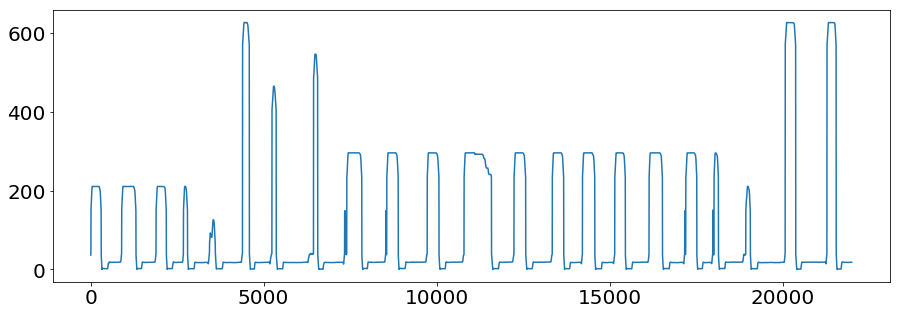

In [88]:
plt.rcParams['figure.figsize'] = [15,5]
plt.plot(linear_distance_arm_shift[100000:122000])
linear_distance_arm_shift[7500:7505]

In [93]:
linear_distance_arm_shift.shape

(122655,)

In [50]:
hardcode_armorder

[7, 5, 4, 1, 0, 2, 3, 6]

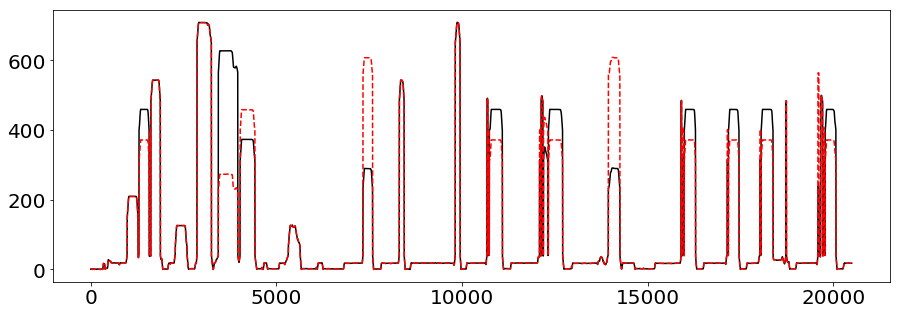

In [348]:
#swaps look like 3<>7 and 4<>5

#plt.plot(pos[2500:4500],posY[2500:4500])
#linear_distance_arm_shift_hmm = linear_distance_arm_shift
#linear_distance_arm_shift_naive = linear_distance_arm_shift
plt.rcParams['figure.figsize'] = [15,5]
plt.plot(linear_distance_arm_shift_hmm[00000:20500],'k')
plt.plot(linear_distance_arm_shift_naive[00000:20500],'r',linestyle='dashed')

#pos_all_linear[7490:7500]

In [76]:
newseg[1000:1010]

array([9., 9., 9., 9., 9., 9., 9., 9., 9., 9.])

In [ ]:
# streamlined version of previous cell
# linearization using eric's code and jen and anna's arm order


In [320]:
linear_distance_arm_shift[3800:3810]
#posX1[0:10000]['linpos_flat'] = linear_distance_arm_shift
posX1[3500:3510]

<_FlatLinearPosition: None, shape: ((10, 2))>

In [ ]:
#linear_distance.groupby('track_segment_id')
import pandas
combined = pandas.DataFrame({'track_segment_id':track_segment_id,'linear_distance':linear_distance})
combined
combined.groupby(['track_segment_id']).max()

In [ ]:
combined.groupby(['track_segment_id']).min()

In [10]:
linear_distance_arm_shift.shape
#pos[0:5000].shape
#pos1 = pos[0:5000]
#posY1 = posY[0:5000]
pos1.shape

(122663, 2)

In [15]:
# define dictionaries for arm swaps

# dictionary to identify arm of the trial
arm_id_dict = {13:'arm1',14:'arm1',15:'arm1',16:'arm1',17:'arm1',18:'arm1',19:'arm1',20:'arm1',21:'arm1',22:'arm1',23:'arm1',24:'arm1',25:'arm1',26:'arm1',27:'arm1',
               29:'arm2',30:'arm2',31:'arm2',32:'arm2',33:'arm2',34:'arm2',35:'arm2',36:'arm2',37:'arm2',38:'arm2',39:'arm2',40:'arm2',41:'arm2',42:'arm2',43:'arm2', 
               46:'arm3',47:'arm3',48:'arm3',49:'arm3',50:'arm3',51:'arm3',52:'arm3',53:'arm3',54:'arm3',55:'arm3',56:'arm3',57:'arm3',58:'arm3',59:'arm3',60:'arm3', 
               64:'arm4',65:'arm4',66:'arm4',67:'arm4',68:'arm4',69:'arm4',70:'arm4',71:'arm4',72:'arm4',73:'arm4',74:'arm4',75:'arm4',76:'arm4',77:'arm4', 
               81:'arm5',82:'arm5',83:'arm5',84:'arm5',85:'arm5',86:'arm5',87:'arm5',88:'arm5',89:'arm5',90:'arm5',91:'arm5',92:'arm5',93:'arm5',94:'arm5', 
               97:'arm6',98:'arm6',99:'arm6',100:'arm6',101:'arm6',102:'arm6',103:'arm6',104:'arm6',105:'arm6',106:'arm6',107:'arm6',108:'arm6',109:'arm6',110:'arm6', 
               113:'arm7',114:'arm7',115:'arm7',116:'arm7',117:'arm7',118:'arm7',119:'arm7',120:'arm7',121:'arm7',122:'arm7',123:'arm7',124:'arm7',125:'arm7',126:'arm7',127:'arm7', 
               130:'arm8',131:'arm8',132:'arm8',133:'arm8',134:'arm8',135:'arm8',136:'arm8',137:'arm8',138:'arm8',139:'arm8',140:'arm8',141:'arm8',142:'arm8',143:'arm8',
              1:'arm0',2:'arm0',3:'arm0',4:'arm0',5:'arm0',6:'arm0',7:'arm0',8:'arm0',9:'arm0',}
# dictionary for new (randomly chosen arm)
new_arm_id_dict = {1:'arm1', 2:'arm2', 3:'arm3', 4:'arm4', 5:'arm5', 6:'arm6', 7:'arm7', 8:'arm8'}
# dictionary for start of arms
arm_start_dict = {'arm1':13, 'arm2':29, 'arm3':46, 'arm4':64, 'arm5':80, 'arm6':97, 'arm7':114, 'arm8':130}
# dictionary for end of arm
arm_end_dict = {'arm1':26, 'arm2':43, 'arm3':60, 'arm4':77, 'arm5':94, 'arm6':110, 'arm7':126, 'arm8':142}
# dictionary for length of arm
arm_length_dict = {'arm0':1,'arm1':26-13, 'arm2':43-29, 'arm3':60-46, 'arm4':77-64, 'arm5':94-80, 
                   'arm6':110-97, 'arm7':126-114, 'arm8':142-130}


In [403]:
arm_id_dict[13]
pos_all_linear
arm_coordinates_WEWANT

array([[  0.,   9.],
       [ 13.,  26.],
       [ 29.,  42.],
       [ 46.,  59.],
       [ 64.,  76.],
       [ 81.,  93.],
       [ 97., 110.],
       [114., 126.],
       [130., 142.]])

In [ ]:
# important changes:
# switch from arm assignment with max to median
# switch defintion of outside of box from 13 to 11
# get rid of arm length correction - all arms about about the same and this causes the positions from 
# other arm visits to get really warped and - maybe we want this...
# this was in line: arm_swap_trial_pos.loc at .values-arm_start)*(new_arm_length/arm_length)
# now only swap the position within the main arm for that trial, and re-introduced the length correction
# now it looks good - all the original gaps are still there
import random

arm_swap_trial_pos_all = pos_all_linear.head(0)
for i in range(len(starttimes_shuffled)):
    arm_swap_trial_pos = pos_all_linear.loc[(pos_all_linear.index.get_level_values('time') <= endtimes_shuffled[i]) & (pos_all_linear.index.get_level_values('time') >= starttimes_shuffled[i])]
    #print(arm_swap_trial_pos[0:1])
    if len(arm_swap_trial_pos[arm_swap_trial_pos['linpos_flat']>11]) > 0:
        #arm_id = arm_id_dict[int(arm_swap_trial_pos['linpos_flat'].max())]
        arm_id = arm_id_dict[int(arm_swap_trial_pos[arm_swap_trial_pos['linpos_flat']>11]['linpos_flat'].median())]
        arm_start = arm_start_dict[arm_id]
        arm_end = arm_end_dict[arm_id]
        arm_length = arm_length_dict[arm_id]
        new_arm_id = new_arm_id_dict[random.randint(1,8)]
        print('Trial: ',indices[i],' Original arm: ',arm_id,' New arm: ',new_arm_id)
        new_arm_start = arm_start_dict[new_arm_id]
        new_arm_length = arm_length_dict[new_arm_id]
        #arm_swap_trial_pos.loc[arm_swap_trial_pos['linpos_flat']>11, ['linpos_flat']] = (((arm_swap_trial_pos[arm_swap_trial_pos['linpos_flat']>11]['linpos_flat'].values-arm_start))+new_arm_start)
        arm_swap_trial_pos.loc[arm_swap_trial_pos['linpos_flat'].between(arm_start, arm_end, inclusive=True), ['linpos_flat']] = (((arm_swap_trial_pos[arm_swap_trial_pos['linpos_flat'].between(arm_start, arm_end, inclusive=True)]['linpos_flat'].values-arm_start)*(new_arm_length/arm_length))+new_arm_start)
        
    else:
        print('box trial')
        
    arm_swap_trial_pos_all = arm_swap_trial_pos_all.append(arm_swap_trial_pos)
    

In [ ]:
arm_swap_trial_pos_all

In [ ]:
arm_swap_trial_pos_all.shape
random_trial_pos_all.shape
arm_end = arm_end_dict[arm_id]
#arm_swap_trial_pos.loc[arm_swap_trial_pos['linpos_flat']>arm_start]
arm_swap_trial_pos[arm_swap_trial_pos['linpos_flat'].between(arm_start, arm_end, inclusive=True)]
arm_swap_trial_pos.loc[arm_swap_trial_pos['linpos_flat'].between(arm_start, arm_end, inclusive=True), ['linpos_flat']]

In [ ]:
for i in range(len(starttimes_shuffled)):
    arm_swap_trial_pos = pos_all_linear.loc[(pos_all_linear.index.get_level_values('time') <= endtimes_shuffled[i]) & (pos_all_linear.index.get_level_values('time') >= starttimes_shuffled[i])]
    #print(arm_swap_trial_pos[0:1])
    if len(arm_swap_trial_pos[arm_swap_trial_pos['linpos_flat']>13]) > 0:
        print(indices[i], len(arm_swap_trial_pos[arm_swap_trial_pos['linpos_flat']>13]))
    else:
        print('box trial')
        

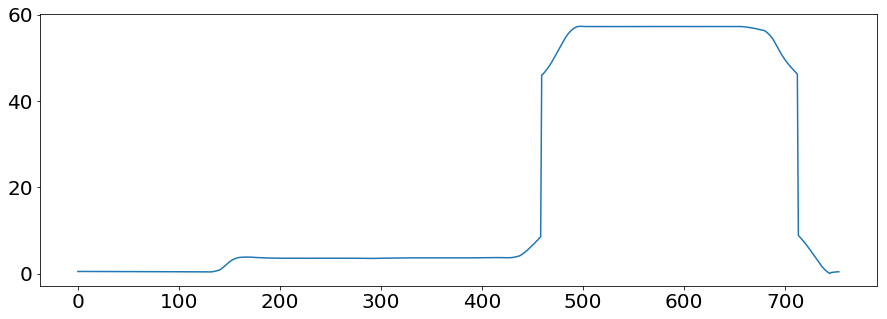

In [224]:
x = 34
example_trial = arm_swap_trial_pos_all.loc[(arm_swap_trial_pos_all.index.get_level_values('time') <= endtimes_shuffled[x]) & (arm_swap_trial_pos_all.index.get_level_values('time') >= starttimes_shuffled[x])]
plt.plot(example_trial['linpos_flat'].values)


(0, 2000)

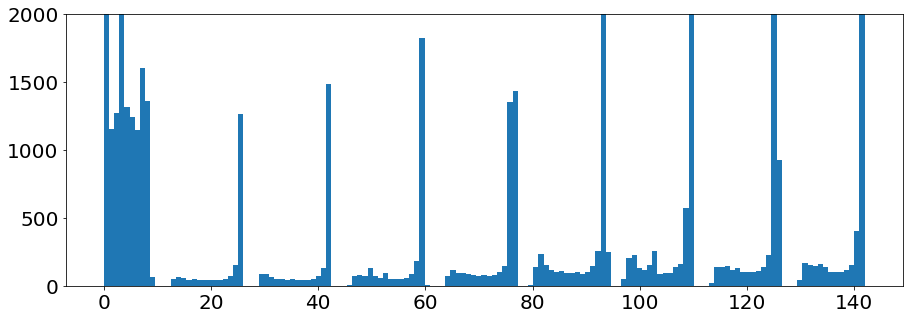

In [13]:
plt.rcParams["figure.figsize"] = [15,5]
#arm_swap_trial_pos.shape
#print(arm_swap_trial_pos[0:1])
#random_trial_pos_all[1000:1010]
#arm_swap_trial_pos_all.loc[(arm_swap_trial_pos_all.index.get_level_values('time') <= 4067) & (arm_swap_trial_pos_all.index.get_level_values('time') >= 4065)]
arm_coordinates_WEWANT
#plt.hist(pos_all_linear['linpos_flat'],200)
plt.hist(arm_swap_trial_pos_all['linpos_flat'],147)
plt.ylim([0,2000])


(0, 2000)

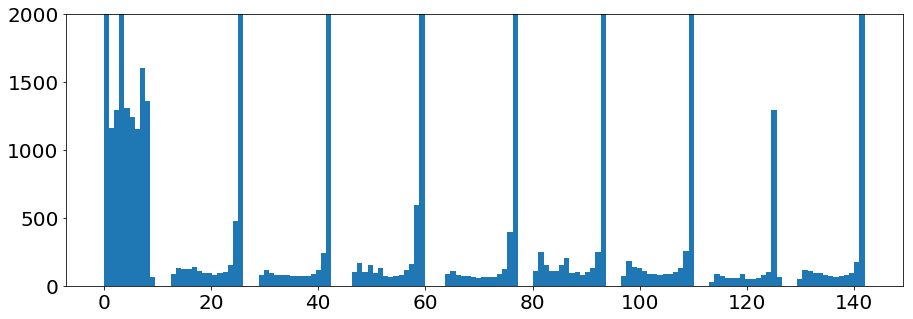

In [242]:
#random_trial_pos_all.shape
#random_trial_pos_all.loc[(random_trial_pos_all.index.get_level_values('time') <= 4067) & (random_trial_pos_all.index.get_level_values('time') >= 4065)]
plt.hist(pos_all_linear['linpos_flat'],147)
#plt.hist(arm_swap_trial_pos_all['linpos_flat'],200)
plt.ylim([0,2000])


In [115]:
arm1_start = 13
arm2_start = 29
arm3_start = 46
arm4_start = 62
arm5_start = 79
arm6_start = 96
arm7_start = 113
arm8_start = 130

arm1_length = 26-13
arm2_length = 42-29
arm3_length = 55-46
arm4_length = 75-62
arm5_length = 92-79
arm6_length = 109-96
arm7_length = 122-113
arm8_length = 142-130

# select one trial to test
example_trial = pos_all_linear.loc[(pos_all_linear.index.get_level_values('time') <= endtimes_shuffled[4]) & (pos_all_linear.index.get_level_values('time') >= starttimes_shuffled[4])]

# ID new and original arms
arm_id = arm_id_dict[int(example_trial['linpos_flat'].max())]
arm_id
arm_start = arm_start_dict[arm_id]
arm_length = arm_length_dict[arm_id]
print('Original arm: ',arm_id)
# random int to assign new arm
new_arm_id = new_arm_id_dict[random.randint(1,8)]
print('New arm: ',new_arm_id)
new_arm_start = arm_start_dict[new_arm_id]
new_arm_length = arm_length_dict[new_arm_id]

#now we need to try to do this in place, while leaving pos in the box intact
#example_trial_outer = example_trial[example_trial['linpos_flat']>13]
#example_trial_outer['linpos_flat'] = ((example_trial_outer['linpos_flat'].values-arm2_start)*(arm7_length/arm2_length))+arm7_start

# expression to transform one arm to coordinates of a different arm
#(((example_trial[example_trial['linpos_flat']>13]['linpos_flat'].values-arm2_start)*(arm7_length/arm2_length))+arm7_start)

# general form to set values in dataframe with conditional
#example_trial.loc[example_trial['linpos_flat']>13, ['linpos_flat']] = 1

# implemented for switching arms
example_trial.loc[example_trial['linpos_flat']>13, ['linpos_flat']] = (((example_trial[example_trial['linpos_flat']>13]['linpos_flat'].values-arm2_start)*(arm7_length/arm2_length))+arm7_start)
#example_trial['linpos_flat'].values
#plt.plot(example_trial[example_trial['linpos_flat']>13]['linpos_flat'].values)
plt.plot(example_trial['linpos_flat'].values)



KeyError: 112

16

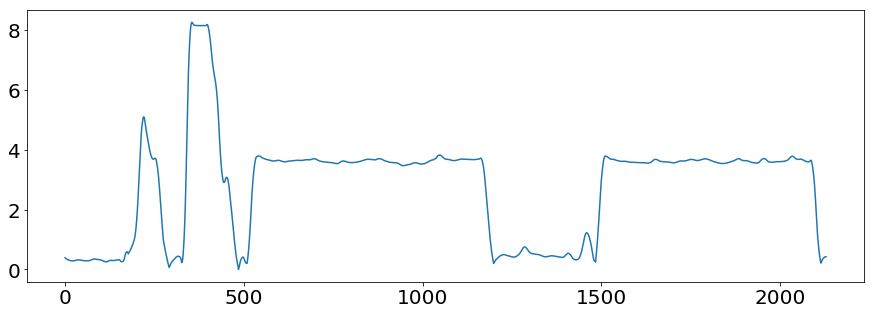

In [185]:
linear_distance_arm_shift.shape
len(linear_distance_arm_shift)
x = 27
example_trial = pos_all_linear.loc[(pos_all_linear.index.get_level_values('time') <= endtimes_shuffled[x]) & (pos_all_linear.index.get_level_values('time') >= starttimes_shuffled[x])]
plt.plot(example_trial['linpos_flat'].values)
#int(example_trial[example_trial['linpos_flat']>13]['linpos_flat'].median())
len(example_trial[example_trial['linpos_flat']>13])
indices[x]

# observations: two nan (trial 27) - invalid trial???, sometimes median is well below end of arm (eg value = 105, 18)
# trial 86 (actually trial 0) has many arm visits - so the shift doesnt make sense - exclude?
# we might have problems because of nose pokes into different arms at beginning of trial (if nose poke arm is higher than actual, trial 92, 101)


In [311]:
arm_coordinates_WEWANT
tracksegment_positionvalues_for_bin_edges
edges_wewant
tracksegments_temp
#binswewant_temp
indiceswewant_temp
#tracksegment_positionvalues_min_and_max_floor
tracksegment_positionvalues_temp

array([154.08079094, 153.70284977, 153.46849369, 153.34832979,
       153.31220982, 153.33221318, 153.38151373, 153.44663478,
       153.52196339, 153.61088675, 153.71054347, 153.79024726,
       153.88002628, 153.94400615, 154.01048944, 154.0716554 ,
       154.14504476, 154.20223749, 154.23606947, 154.25111579,
       154.25318818, 154.24109941, 154.21253054, 154.16573575,
       154.0959685 , 154.01135982, 153.93078173, 153.82756168,
       153.62865197, 153.50788494, 153.4156106 , 153.33447205,
       153.26192199, 153.20253796, 153.15989923, 153.15932745,
       153.17674414, 153.21548396, 153.23097785, 153.28015817,
       153.35744594, 153.49192579, 153.64899823, 153.813955  ,
       154.09878839, 154.2240336 , 154.23685086, 154.22707433,
       154.2005248 , 154.15048197, 154.04323936, 153.88196529,
       153.72004101, 153.54576699, 153.38262391, 153.29232469,
       153.23611923, 153.19928711, 153.15636721, 153.11830103,
       153.09000376, 153.09573648, 153.13865677, 153.21

In [318]:

arm_coordinates_WEWANT = arm_coordinates_WEWANT/5
arm_coordinates_WEWANT = np.around(arm_coordinates_WEWANT)
arm_coordinates_WEWANT

array([[  0.,   9.],
       [ 13.,  26.],
       [ 29.,  42.],
       [ 46.,  58.],
       [ 62.,  75.],
       [ 79.,  92.],
       [ 96., 109.],
       [113., 126.],
       [130., 142.]])

In [12]:
#save position as netcdf
linear_pos1 = pos_all_linear.reset_index()
linear_pos2 = linear_pos1.to_xarray()
linear_pos2.to_netcdf('/data2/mcoulter/remy_20_2_new_linear_pos.nc')

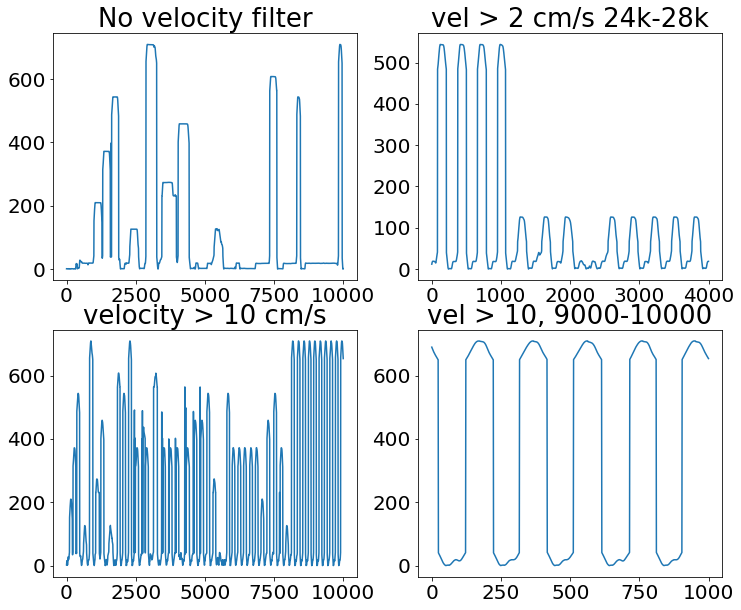

In [135]:
plt.rcParams["figure.figsize"] = [12,10]
plt.rcParams.update({'figure.titlesize': 'medium'})
fig, axs = plt.subplots(2,2)

linear_distance_arm_shift.shape
pos_subset.loc[(pos_subset["linvel_flat"]>10)]
pos_subset["linvel_flat"]
#pos_subset_test = pos_subset
#pos_subset_test = pos_subset_test.reset_index()
#pos_100 = pos_subset_test[0:100]
pos_vel_10 = pos_subset_test.loc[(pos_subset_test["linvel_flat"]>10)]
pos_vel_2 = pos_subset_test.loc[(pos_subset_test["linvel_flat"]>2)]
#pos_vel_10
lin_vel_10 = linear_distance_arm_shift[pos_vel_10.index]
lin_vel_2 = linear_distance_arm_shift[pos_vel_2.index]

axs[0,0].plot((linear_distance_arm_shift[0:10000]))
axs[0,0].title.set_text('No velocity filter')
axs[1,0].plot((lin_vel_10[0:10000]))
axs[1,0].title.set_text('velocity > 10 cm/s')
axs[0,1].plot((lin_vel_2[24000:28000]))
axs[0,1].title.set_text('vel > 2 cm/s 24k-28k')
axs[1,1].plot((lin_vel_10[9000:10000]))
axs[1,1].title.set_text('vel > 10, 9000-10000')
#linear_distance_arm_shift[pos_vel_10.index]
np.savetxt("/data2/mcoulter/linearized_pos_10cm_filter.csv",lin_vel_10,delimiter=',')

In [366]:
# Define encoding settings #? Ideally would only define once
# we dont have a bin for the blank 15cm bin between each segment
# 1-13-19 update bin info for 10cm bins - removed because these changes didnt work:
# the encoding went everywhere and didnt adhere to the gaps between the arms
# the extra added to max_pos matched the hardcoded gap from the linearization

#max_pos = int(round(linear_distance_arm_shift.max()) + 20)

# to use for 5cm bins
max_pos = int(round(linear_distance_arm_shift.max()/5) + 5)

encode_settings = AttrDict({'sampling_rate': 3e4,
                            'pos_bins': np.arange(0,max_pos,1), # arm_coords_wewant
                            'pos_bin_edges': np.arange(0,max_pos + .1,1), # edges_wewant, 
                            'pos_bin_delta': 1,
                            # 'pos_kernel': sp.stats.norm.pdf(arm_coords_wewant, arm_coords_wewant[-1]/2, 1),
                            'pos_kernel': sp.stats.norm.pdf(np.arange(0,max_pos,1), max_pos/2, 1), #note that the pos_kernel mean should be half of the range of positions (ie 180/90) # sp.stats.norm.pdf(np.arange(0,560,1), 280, 1), 
                            'pos_kernel_std': 1, 
                            'mark_kernel_std': int(20), 
                            'pos_num_bins': max_pos, # len(arm_coords_wewant)
                            'pos_col_names': [pos_col_format(ii, max_pos) for ii in range(max_pos)], # or range(0,max_pos,10)
                            'arm_coordinates': arm_coordinates_WEWANT}) # includes box, removes bins in the gaps 'arm_coordinates': [[0,max_pos]]})



In [20]:
#edges = encode_settings.pos_bin_edges
edges = pd.DataFrame(data=encode_settings.pos_bin_edges,index=np.arange(0,148),columns=np.arange(0,1))
edges.to_csv('/data2/mcoulter/pos_bin_edges.csv')
#edges

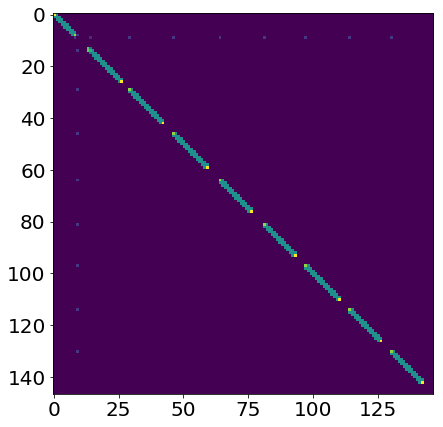

In [411]:
from scipy.sparse import diags

n = len(encode_settings.pos_bins)
transition_mat = np.zeros([n,n])
k = np.array([(1/3)*np.ones(n-1),(1/3)*np.ones(n),(1/3)*np.ones(n-1)])
offset = [-1,0,1]
transition_mat = diags(k,offset).toarray()

# move start of arm 1 to 14 instead of 13 to skip the nearly empty bin
for x in [  0.,  14.,  29.,  46.,  64.,  81.,  97., 114., 130.]:
#for x in encode_settings.arm_coordinates[:,0]:
    transition_mat[int(x),int(x)] = (5/9)
    transition_mat[9,int(x)] = (1/9)
    transition_mat[int(x),9] = (1/9)
for y in encode_settings.arm_coordinates[:,1]:
    transition_mat[int(y),int(y)] = (2/3)
transition_mat[9,0] = 0
transition_mat[0,9] = 0
transition_mat[9,9] = 0
transition_mat[0,0] = (2/3)
transition_mat[8,8] = (5/9)
transition_mat[8,9] = (1/9)
transition_mat[9,8] = (1/9)

# uniform offset
# gain = 0.001
#uniform_gain = decode_settings.trans_uniform_gain
uniform_gain = 0.0001
uniform_dist = np.ones(transition_mat.shape)*uniform_gain
        
# no-animal boundary
#uniform_dist = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, uniform_dist)

# normalize uniform offset
#uniform_dist = uniform_dist / (uniform_dist.sum(axis=0)[None, :])
#uniform_dist[np.isnan(uniform_dist)] = 0


# apply uniform offset
transition_mat = transition_mat + uniform_dist

# apply no animal boundary - make gaps between arms
transition_mat = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, transition_mat)

# instead of gaussian smoother you can just take the transition matrix to a power - this will sorta do the same thing
transition_mat = np.linalg.matrix_power(transition_mat,1)

# apply no animal boundary - make gaps between arms
transition_mat = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, transition_mat)

#normalize
transition_mat = transition_mat / (transition_mat.sum(axis=0)[None, :])
transition_mat[np.isnan(transition_mat)] = 0

transition_mat[9,:]
plt.imshow(transition_mat)
#plt.plot(transition_mat[9,:])
trans_mat_pandas = pd.DataFrame(data=transition_mat,index=np.arange(0,147),columns=np.arange(0,147))
trans_mat_pandas.to_csv('/data2/mcoulter/trans_mat_arm1_start_shift.csv')

In [412]:
transition_mat[9,:]

array([9.88337616e-05, 9.88337616e-05, 9.88337616e-05, 9.88337616e-05,
       9.88337616e-05, 9.88337616e-05, 9.88337616e-05, 9.88337616e-05,
       1.09914124e-01, 9.88337616e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.47391176e-04, 8.26766450e-02, 9.88337616e-05,
       9.88337616e-05, 9.88337616e-05, 9.88337616e-05, 9.88337616e-05,
       9.88337616e-05, 9.88337616e-05, 9.88337616e-05, 9.88337616e-05,
       9.88337616e-05, 9.88337616e-05, 9.88337616e-05, 0.00000000e+00,
       0.00000000e+00, 1.09914124e-01, 9.88337616e-05, 9.88337616e-05,
       9.88337616e-05, 9.88337616e-05, 9.88337616e-05, 9.88337616e-05,
       9.88337616e-05, 9.88337616e-05, 9.88337616e-05, 9.88337616e-05,
       9.88337616e-05, 9.88337616e-05, 9.88337616e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.09914124e-01, 9.88337616e-05,
       9.88337616e-05, 9.88337616e-05, 9.88337616e-05, 9.88337616e-05,
       9.88337616e-05, 9.88337616e-05, 9.88337616e-05, 9.88337616e-05,
      

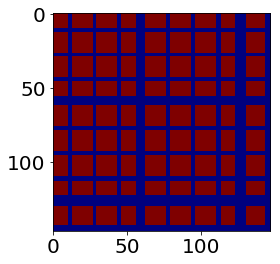

In [147]:
#uniform transition matrix for eric

n = len(encode_settings.pos_bins)
transition_mat = np.ones([n,n])

# apply no animal boundary - make gaps between arms
transition_mat = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, transition_mat)

#normalize
transition_mat = transition_mat / (transition_mat.sum(axis=0)[None, :])
transition_mat[np.isnan(transition_mat)] = 0

plt.imshow(transition_mat,cmap='jet')
trans_mat_pandas = pd.DataFrame(data=transition_mat,index=np.arange(0,147),columns=np.arange(0,147))
trans_mat_pandas.to_csv('/data2/mcoulter/MEC_uniform_transition_matrix_5cm_norm_no_offset_2_15_19_.csv')

In [161]:
a = np.arange(1,5).reshape((2,2))
a
a@a
np.linalg.matrix_power(a,2)

array([[ 7, 10],
       [15, 22]])

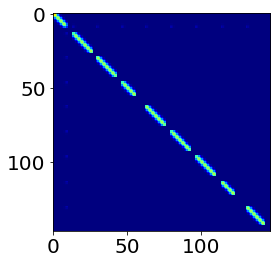

In [14]:
from scipy.sparse import diags

n = len(encode_settings.pos_bins)
transition_mat = np.zeros([n,n])
k = np.array([(1/3)*np.ones(n-1),(1/3)*np.ones(n),(1/3)*np.ones(n-1)])
offset = [-1,0,1]
transition_mat = diags(k,offset).toarray()

for x in encode_settings.arm_coordinates[:,0]:
    transition_mat[int(x),int(x)] = (5/9)
    transition_mat[9,int(x)] = (1/9)
    transition_mat[int(x),9] = (1/9)
for y in encode_settings.arm_coordinates[:,1]:
    transition_mat[int(y),int(y)] = (2/3)
transition_mat[9,0] = 0
transition_mat[0,9] = 0
transition_mat[9,9] = 0
transition_mat[0,0] = (2/3)
transition_mat[8,8] = (5/9)
transition_mat[8,9] = (1/9)
transition_mat[9,8] = (1/9)

# uniform offset
# gain = 0.001
#uniform_gain = decode_settings.trans_uniform_gain
uniform_gain = 0.001
uniform_dist = np.ones(transition_mat.shape)*uniform_gain
        
# no-animal boundary
#uniform_dist = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, uniform_dist)

# normalize uniform offset
#uniform_dist = uniform_dist / (uniform_dist.sum(axis=0)[None, :])
#uniform_dist[np.isnan(uniform_dist)] = 0

# apply uniform offset
transition_mat = transition_mat + uniform_dist

# apply no animal boundary - make gaps between arms
transition_mat = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, transition_mat)

# gaussian smoother 
transition_mat = scipy.ndimage.filters.gaussian_filter(transition_mat,1)

# apply no animal boundary - make gaps between arms
transition_mat = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, transition_mat)

transition_mat[9,:]
plt.imshow(transition_mat,cmap='jet')
#plt.plot(transition_mat[9,:])
#trans_mat_pandas = pd.DataFrame(data=transition_mat,index=np.arange(0,147),columns=np.arange(0,147))
#trans_mat_pandas.to_csv('/data2/mcoulter/MEC_flat_transition_matrix_5cm_2_15_19_gauss.csv')

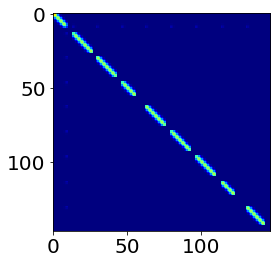

In [15]:
from scipy.sparse import diags
from scipy.stats import norm

n = len(encode_settings.pos_bins)
transition_mat = np.zeros([n,n])
norm(loc=1,scale=1).pdf(b)
bin_centers = encode_settings.pos_bins
transition_ = np.asarray([norm(loc=bin, scale=movement_std).pdf(bin_centers) for bin in bin_centers])
#k = np.array([(1/3)*np.ones(n-1),(1/3)*np.ones(n),(1/3)*np.ones(n-1)])
offset = [-1,0,1]
transition_mat = diags(k,offset).toarray()

for x in encode_settings.arm_coordinates[:,0]:
    transition_mat[int(x),int(x)] = (5/9)
    transition_mat[9,int(x)] = (1/9)
    transition_mat[int(x),9] = (1/9)
for y in encode_settings.arm_coordinates[:,1]:
    transition_mat[int(y),int(y)] = (2/3)
transition_mat[9,0] = 0
transition_mat[0,9] = 0
transition_mat[9,9] = 0
transition_mat[0,0] = (2/3)
transition_mat[8,8] = (5/9)
transition_mat[8,9] = (1/9)
transition_mat[9,8] = (1/9)

# uniform offset
# gain = 0.001
#uniform_gain = decode_settings.trans_uniform_gain
uniform_gain = 0.001
uniform_dist = np.ones(transition_mat.shape)*uniform_gain
        
# no-animal boundary
#uniform_dist = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, uniform_dist)

# normalize uniform offset
#uniform_dist = uniform_dist / (uniform_dist.sum(axis=0)[None, :])
#uniform_dist[np.isnan(uniform_dist)] = 0

# apply uniform offset
transition_mat = transition_mat + uniform_dist

# apply no animal boundary - make gaps between arms
transition_mat = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, transition_mat)

# gaussian smoother 
transition_mat = scipy.ndimage.filters.gaussian_filter(transition_mat,1)

# apply no animal boundary - make gaps between arms
transition_mat = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, transition_mat)

transition_mat[9,:]
plt.imshow(transition_mat,cmap='jet')
#plt.plot(transition_mat[9,:])
#trans_mat_pandas = pd.DataFrame(data=transition_mat,index=np.arange(0,147),columns=np.arange(0,147))
#trans_mat_pandas.to_csv('/data2/mcoulter/MEC_flat_transition_matrix_5cm_2_15_19_gauss.csv')

In [399]:
plt.imshow((transition_mat)^1000,cmap='jet')

NameError: name 'transition_mat' is not defined

In [ ]:
transition_matrix = np.array

In [368]:
#define decode settings
decode_settings = AttrDict({'trans_smooth_std': 2,
                            'trans_uniform_gain': 0.0001,
                            'time_bin_size':60})

In [ ]:
# Define directory for pickling 
directory_pickling = path_base_foranalysisofonesessionepoch + '/encoder_output/'
print('results will be saved in:',directory_pickling)
change_to_directory_make_if_nonexistent(directory_path = directory_pickling)

In [375]:
%%time
# note: notch filter is currently hard-coded into pp_clusterless.py - removed 3/25/19
#8-31:remove speed_thresh, add dec_spk_amp, add decode_settings
# these time-table lines are so that we can record the time it takes for encoder to run even if notebook disconnects
# look at the time stamps for the two files in /data2/mcoulter called time_stamp1 and time_stamp2
time_table_data = {'age': [1, 2, 3, 4, 5]}
time_table = pd.DataFrame(time_table_data)
time_table.to_csv('/data2/mcoulter/time_stamp1.csv')

# for whole epoch: use linflat=pos1 or pos_all_linear
# for subset: use linflat=pos_subset
# dec_spk_amp = spk_subset_sparse_decode_filt
# enc_spk_amp = spk_subset_sparse_encode

encoder = OfflinePPEncoder(linflat=pos_all_linear, dec_spk_amp=marks, encode_settings=encode_settings, 
                           decode_settings=decode_settings, enc_spk_amp=marks, dask_worker_memory=1e9,
                           dask_chunksize = None)

#encoder.run_encoder(directory_pickling)
#results = encoder.run_encoder()

#new way to output results
encoder_output = encoder.run_encoder()
results = encoder_output['results']
prob_no_spike = encoder_output['prob_no_spike']
trans_mat = encoder_output['trans_mat']

time_table.to_csv('/data2/mcoulter/time_stamp2.csv')

16:48:41 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Dask chunksize: 565
16:48:41 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Memory utilization at: 50.0%
16:48:41 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Expected worker peak memory usage: 476.11 MB


convolution occupancy normalization test


INFO:root:Setting up encoder dask task.
INFO:root:Running compute tasks on dask workers.


CPU times: user 45min 35s, sys: 43min 46s, total: 1h 29min 21s
Wall time: 2min 15s


(147, 147)

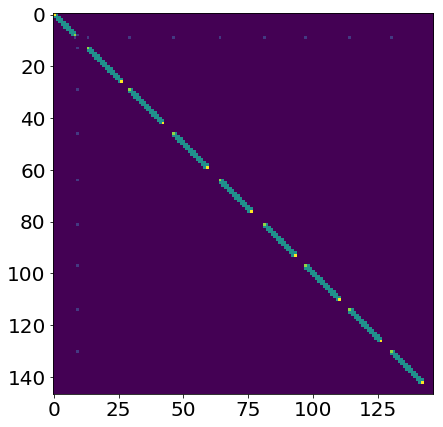

In [395]:
results
trans_mat
plt.imshow(trans_mat)
trans_mat.shape

In [400]:
plt.imshow(trans_mat^10000)

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [398]:
flat_powered_trans_mat = pd.DataFrame(data=trans_mat,index=np.arange(0,147),columns=np.arange(0,147))
flat_powered_trans_mat.to_csv('/data2/mcoulter/flat_power_trans_05_17_19.csv')

In [19]:
%%time
#from dan notebook decoding/encoding_alogrithm
#to make observations table from results

#tet_ids = np.unique(spk_subset_sparse.index.get_level_values('elec_grp_id'))
tet_ids = np.unique(spk_subset_sparse_decode_filt.index.get_level_values('elec_grp_id'))
observ_tet_list = []
#grp = spk_subset_sparse.groupby('elec_grp_id')
grp = spk_subset_sparse_decode_filt.groupby('elec_grp_id')
for tet_ii, (tet_id, grp_spk) in enumerate(grp):
    tet_result = results[tet_ii]
    tet_result.set_index(grp_spk.index, inplace=True)
    observ_tet_list.append(tet_result)

observ = pd.concat(observ_tet_list)
observ_obj = SpikeObservation.create_default(observ.sort_index(level=['day', 'epoch', 
                                                                      'timestamp', 'elec_grp_id']), 
                                             encode_settings)

observ_obj['elec_grp_id'] = observ_obj.index.get_level_values('elec_grp_id')
observ_obj.index = observ_obj.index.droplevel('elec_grp_id')

CPU times: user 2.19 s, sys: 2.38 s, total: 4.56 s
Wall time: 344 ms


In [15]:
results[4]

KeyError: 4

In [20]:
%%time
# do we need this cell anymore???
# yes! this prevents 0s in the observation table and then prevents NaN from showing up in the likelihoods

# Add small offset to observation distributions to prevent numerical instability due to precision# Add sm 
#observ_obj.loc[:, 'x000':'x740'] = observ_obj.loc[:, 'x000':'x740'].values + 1e-20
observ_obj.loc[:, 'x000':'x146'] = observ_obj.loc[:, 'x000':'x146'].values + np.spacing(1)

CPU times: user 12.2 s, sys: 2.49 s, total: 14.7 s
Wall time: 9.14 s


In [197]:
# to store observations table
#observ_obj[17245:17255]
#observ_obj.to_csv('/data2/mcoulter/observations_object_1cm-2-3-19.csv')
#observ_obj._to_hdf_store('/data2/mcoulter/remy_20_2_observ_0_65000_2_18_19.h5','/analysis', 
#                         'decode/clusterless/offline/observ_obj', 'observ_obj')

# to store observations for a single ripple
observ_obj = observ_obj.reset_index()
ripple_obs = observ_obj.loc[(observ_obj["time"]>2864.49) & (observ_obj["time"]<2864.706)]
ripple_obs.to_csv('/data2/mcoulter/observations_ripple_362.csv')

In [15]:
# hacky but reliable way to load a dataframe stored as hdf
# Posteriors is imported from data_containers
observ_obj = Posteriors._from_hdf_store('/data2/mcoulter/remy_20_2_observations_whole_epoch.h5','/analysis', 
                         'decode/clusterless/offline/observ_obj', 'observ_obj')

In [19]:
observ_obj

<SpikeObservation: None, shape: ((1928055, 148))>

In [21]:
# define the term encoder, so that you can access the transition matrix
# use this if you are loading and observation table that has already been encoded
# this doesnt work because it just tries to run the encoder
#pos1 = pos
#encoder = OfflinePPEncoder(linflat=pos1, dec_spk_amp=spk_subset_sparse_decode_filt, encode_settings=encode_settings, 
#                           decode_settings=decode_settings, enc_spk_amp=spk_subset_sparse_encode, dask_worker_memory=1e9,
#                           dask_chunksize = None)

#define the transition matrix you want to use in the decoder
from scipy.sparse import diags
n = len(encode_settings.pos_bins)
transition_mat = np.zeros([n,n])
k = np.array([(1/3)*np.ones(n-1),(1/3)*np.ones(n),(1/3)*np.ones(n-1)])
offset = [-1,0,1]
transition_mat = diags(k,offset).toarray()
for x in encode_settings.arm_coordinates[:,0]:
    transition_mat[int(x),int(x)] = (5/9)
    transition_mat[9,int(x)] = (1/9)
    transition_mat[int(x),9] = (1/9)
for y in encode_settings.arm_coordinates[:,1]:
    transition_mat[int(y),int(y)] = (2/3)
transition_mat[9,0] = 0
transition_mat[0,9] = 0
transition_mat[9,9] = 0
transition_mat[0,0] = (2/3)
transition_mat[8,8] = (5/9)
transition_mat[8,9] = (1/9)
transition_mat[9,8] = (1/9)

# uniform offset (gain, currently 0.0001)
# needs to be set before running the encoder cell
uniform_gain = decode_settings.trans_uniform_gain
uniform_dist = np.ones(transition_mat.shape)*uniform_gain

# apply uniform offset
transition_mat = transition_mat + uniform_dist

# apply no animal boundary - make gaps between arms
transition_mat = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, transition_mat)

# to smooth: take the transition matrix to a power
transition_mat = np.linalg.matrix_power(transition_mat,1)

# apply no animal boundary - make gaps between arms
transition_mat = apply_no_anim_boundary(encode_settings.pos_bins, encode_settings.arm_coordinates, transition_mat)
        
# normalize transition matrix
transition_mat = transition_mat/(transition_mat.sum(axis=0)[None, :])
transition_mat[np.isnan(transition_mat)] = 0


        


In [ ]:
# define prob_no_spike
tet_id
tet_fr
occupancy

prob_no_spike = {}
for tet_id, tet_fr in firing_rate.items():
    prob_no_spike[tet_id] = np.exp(-decode_settings.time_bin_size/encode_settings.sampling_rate * tet_fr / occupancy)
return prob_no_spike

In [3]:
# load observations, prob_no_spike, and transition matrix
    # load previously generated observations
    # hacky but reliable way to load a dataframe stored as hdf
    # Posteriors is imported from data_containers
observ_obj = Posteriors._from_hdf_store('/data2/mcoulter/remy_20_2_pos_sort3_vel4_mask_convol_new_pos_yes_random_marks_shuffle_observations_4_29_19.h5','/analysis', 
                         'decode/clusterless/offline/observ_obj', 'observ_obj')

#load prob_no_spike - this is a dictionary
probability_no_spike = np.load('/data2/mcoulter/remy_20_2_pos_sort3_vel4_mask_convol_new_pos_yes_random_marks_shuffle_prob_no_spike_4_29_19.npy').item()

#load transition matrix - this is an array
transition_matrix = np.load('/data2/mcoulter/remy_20_2_pos_sort3_vel4_mask_convol_new_pos_yes_random_marks_shuffle_trans_mat_4_29_19.npy')

In [7]:
transition_matrix[0]

array([6.59316391e-01, 3.29707637e-01, 9.88826263e-05, 9.88826263e-05,
       9.88826263e-05, 9.88826263e-05, 9.88826263e-05, 9.88826263e-05,
       9.88826263e-05, 9.88826263e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.88826263e-05, 9.88826263e-05, 9.88826263e-05,
       9.88826263e-05, 9.88826263e-05, 9.88826263e-05, 9.88826263e-05,
       9.88826263e-05, 9.88826263e-05, 9.88826263e-05, 9.88826263e-05,
       9.88826263e-05, 9.88826263e-05, 9.88826263e-05, 0.00000000e+00,
       0.00000000e+00, 9.88826263e-05, 9.88826263e-05, 9.88826263e-05,
       9.88826263e-05, 9.88826263e-05, 9.88826263e-05, 9.88826263e-05,
       9.88826263e-05, 9.88826263e-05, 9.88826263e-05, 9.88826263e-05,
       9.88826263e-05, 9.88826263e-05, 9.88826263e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.88826263e-05, 9.88826263e-05,
       9.88826263e-05, 9.88826263e-05, 9.88826263e-05, 9.88826263e-05,
       9.88826263e-05, 9.88826263e-05, 9.88826263e-05, 9.88826263e-05,
      

In [29]:
%%time
# Run PP decoding algorithm
# NOTE 1-11-19 had to add spk_amp and vel to encode settings in order for decoding to run
# from bond_single.json, vel = 0 and spk_amp = 60

time_bin_size = 60
max_pos = int(round(linear_distance_arm_shift.max()/5) + 5)

# note: if you change trans_uniform_gain here it will not get updated when making the transition matrix :(
decode_settings = AttrDict({'trans_smooth_std': 2,
                            'trans_uniform_gain': 0.0001,
                            'time_bin_size':60})

encode_settings = AttrDict({'sampling_rate': 3e4,
                            'pos_bins': np.arange(0,max_pos,1), # arm_coords_wewant
                            'pos_bin_edges': np.arange(0,max_pos + .1,1), # edges_wewant, 
                            'pos_bin_delta': 1, 
                            # 'pos_kernel': sp.stats.norm.pdf(arm_coords_wewant, arm_coords_wewant[-1]/2, 1),
                            'pos_kernel': sp.stats.norm.pdf(np.arange(0,max_pos,1), max_pos/2, 1), #note that the pos_kernel mean should be half of the range of positions (ie 180/90) # sp.stats.norm.pdf(np.arange(0,560,1), 280, 1),    
                            'pos_kernel_std': 1, 
                            'mark_kernel_std': int(20), 
                            'pos_num_bins': max_pos, # len(arm_coords_wewant)
                            'pos_col_names': [pos_col_format(ii, max_pos) for ii in range(max_pos)], # [pos_col_format(int(ii), len(arm_coords_wewant)) for ii in arm_coords_wewant],
                            'arm_coordinates': arm_coordinates_WEWANT, # 'arm_coordinates': [[0,max_pos]]})
                            #'arm_coordinates': ([[0,53],[74,140],[151,221],[236,285],[311,378],[397,460],[484,486],[565,615],[659,725]]),
                            'spk_amp': 60,
                            'vel': 0})

#when you ran the encoder in the notebook use: trans_mat=encoder.trans_mat['flat_powered'], encoder.prob_no_spike
#when loading an observations table use: trans_mat=transition_mat
decoder = OfflinePPDecoder(observ_obj=observ_obj, trans_mat=transition_matrix, 
                           prob_no_spike=probability_no_spike,
                           encode_settings=encode_settings, decode_settings=decode_settings, 
                           time_bin_size=time_bin_size, all_linear_position=pos_all_linear, velocity_filter=4)

posteriors = decoder.run_decoder()
#likelihoods = decoder.run_decoder()


Beginning likelihood calculation
(1904645, 152)
missing bins:  (1904645, 152)
observ bins:  (1904645, 152)
(1904645, 152)
(1904645, 152)
missing bins:  (1904645, 152)
update_num_missing:  (1904645, 152)
spikes parallel:  (1034, 152)
num missing index:  range(0, 150)
spikes parallel:  (547, 152)
num missing index:  range(0, 150)
spikes parallel:  (320, 152)
num missing index:  range(0, 150)
spikes parallel:  (1105, 152)
num missing index:  range(0, 150)
spikes parallel: likelihoods single bin:  (196, 150)
spikes parallel:  (320, 152)
num missing index:  range(0, 150)
 (1093, 152)
num missing index:  range(0, 150)
spikes parallel:  (1284, 152)
num missing index:  range(0, 150)
spikes parallel:  (1188, 152)
num missing index:  range(0, 150)
spikes parallel:  (855, 152)
num missing index:  range(0, 150)
spikes parallel:  (933, 152)
num missing index:  range(0, 150)
spikes parallel:  (807, 152)
num missing index:  range(0, 150)
spikes parallel:  (1413, 152)
num missing index:  range(0, 150)

num missing index:  range(0, 150)
spikes parallel:  (1014, 152)
num missing index:  likelihoods single bin: range(0, 150)
 (1001, 150)
likelihoods single bin:  (997, 150)
spikes parallel:  (616, 152)spikes parallel:  (448, 152)
num missing index:  range(0, 150)
likelihoods single bin: 
num missing index:   range(0, 150)
(635, 150)
likelihoods single bin:  (1000, 150)
spikes parallel:  (1012, 152)
num missing index:  range(0, 150)
likelihoods single bin:  (534, 150)
spikes parallel:  (1429, 152)
num missing index:  range(0, 150)spikes parallel:  (1181, 152)
num missing index:  range(0, 150)

spikes parallel:  (1095, 152)
num missing index:  range(0, 150)
likelihoods single bin:  (1000, 150)
spikes parallel:  (1338, 152)
num missing index: likelihoods single bin:  (1000, 150)
 range(0, 150)
likelihoods single bin: likelihoods single bin:  (999, 150)
 (999, 150)
spikes parallel:  (1190, 152)
num missing index:  range(0, 150)
spikes parallel:  (1001, 152)
num missing index:  range(0, 150)


spikes parallel:  (542, 152)
num missing index: likelihoods single bin:   range(0, 150)
spikes parallel:  (631, 152)
(1000, 150)num missing index:  range(0, 150)

likelihoods single bin:  (999, 150)spikes parallel:  (1170, 152)
num missing index:  range(0, 150)
likelihoods single bin: 
 (1002, 150)
spikes parallel:  spikes parallel: (1179, 152)
num missing index:  range(0, 150)
 (324, 152)
num missing index:  range(0, 150)
likelihoods single bin:  (2824, 150)
likelihoods single bin:  (1001, 150)
spikes parallel:  (219, 152)
num missing index:  range(0, 150)
spikes parallel:  (959, 152)
num missing index:  range(0, 150)
likelihoods single bin:  (1005, 150)
likelihoods single bin: spikes parallel:  (1596, 152)
num missing index:  range(0, 150)
likelihoods single bin:   (998, 150)
(830, 150)
spikes parallel:  (1032, 152)
num missing index:  range(0, 150)spikes parallel:  (1215, 152)
num missing index:  range(0, 150)

likelihoods single bin:  (2706, 150)
spikes parallel:  (417, 152)
num mi

spikes parallel:  (1088, 152)
num missing index:  range(0, 150)
spikes parallel:  (451, 152)
num missing index:  range(0, 150)
likelihoods single bin:  (996, 150)
spikes parallel:  (1311, 152)
num missing index:  range(0, 150)
likelihoods single bin: likelihoods single bin:  (999, 150)
likelihoods single bin:  (1000, 150)
 (999, 150)
spikes parallel:  (784, 152)
num missing index:  range(0, 150)
spikes parallel:  (1279, 152)
num missing index:  range(0, 150)
likelihoods single bin:  (1001, 150)
spikes parallel:  (1275, 152)
num missing index:  range(0, 150)
likelihoods single bin:  (999, 150)
spikes parallel:  (1131, 152)
likelihoods single bin:  (1899, 150)
num missing index:  range(0, 150)
spikes parallel:  (1000, 152)
num missing index:  range(0, 150)
likelihoods single bin: spikes parallel:  (976, 152)
num missing index:  range(0, 150)
 (1008, 150)
likelihoods single bin:  (999, 150)
likelihoods single bin:  (1000, 150)
likelihoods single bin: spikes parallel:  (1262, 152)
num miss

KeyboardInterrupt: 

In [26]:
posteriors
#decoder.likelihoods

<Posteriors: None, shape: ((2052202, 149))>

In [60]:
import xarray as xr

def convert_dan_posterior_to_xarray(posterior_df, position_bin_centers=None):
    '''Converts pandas dataframe from Dan's 1D decoder to xarray Dataset
    
    Parameters
    ----------
    posterior_df : pandas.DataFrame, shape (n_time, n_columns)
    position_bin_centers : None or ndarray, shape (n_position_bins,), optional
    
    Returns
    -------
    results : xarray.Dataset
    
    '''
    is_position_bin = posterior_df.columns.str.startswith('x')
    
    if position_bin_centers is None:
        n_position_bins = is_position_bin.sum()
        position_bin_centers = np.arange(n_position_bins)
        
    coords = dict(
        day=posterior_df.loc[:, 'day'].values,
        epoch=posterior_df.loc[:, 'epoch'].values,
        timestamp=posterior_df.loc[:, 'timestamp'].values,
        time=posterior_df.loc[:, 'time'].values,
        position=position_bin_centers,
        num_spikes=posterior_df.loc[:, 'num_spikes'].values,
        dec_bin=posterior_df.loc[:, 'dec_bin'].values,
        ripple_grp=posterior_df.loc[:, 'ripple_grp'].values,
    )

    return xr.Dataset(
        {'causal_posterior': (('time','position'), posterior_df.loc[:, is_position_bin].values)},
        coords=coords)

In [62]:
post1 = posteriors.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
post2 = post1.reset_index()
post3 = convert_dan_posterior_to_xarray(post2)
post3.to_netcdf('/data2/mcoulter/posteriors/remy_20_2_new_format_test.nc')

/home/mcoulter/anaconda3/lib/python3.6/site-packages/dask/utils.py:1014: UserWarning:
Deprecated, see dask.base.get_scheduler instead


In [31]:
post2

<_Posteriors: None, shape: ((166610, 154))>

In [62]:
pos_flat = pos_subset.reset_index()
ripple_pos = pos_flat.loc[(pos_flat["time"]>1760) & (pos_flat["time"]<1848)]
ripple_pos
ripple_pos.to_csv('/data2/mcoulter/pos_arm_movement_1760_1848.csv')
ripple_pos

<___FlatLinearPosition: None, shape: ((2618, 6))>

In [64]:
likelihoods
likelihoods = likelihoods.reset_index(level="timestamp", drop=True)
likelihoods = likelihoods.reset_index()
ripple_like = likelihoods.loc[(likelihoods["time"]>1760) & (likelihoods["time"]<1848)]
ripple_like.to_csv('/data2/mcoulter/likelihood_arm_movement_1760_1848.csv')
ripple_like

day  epoch      time    x000    x001    x002    x003   ...       x143  \
31097   20      2  1760.002  0.9826  0.9796  0.9763  0.9760   ...     1.0000   
31098   20      2  1760.004  0.0090  0.0093  0.0089  0.0076   ...     0.0051   
31099   20      2  1760.006  0.0102  0.0095  0.0086  0.0090   ...     0.0082   
31100   20      2  1760.008  0.0120  0.0121  0.0104  0.0078   ...     0.0039   
31101   20      2  1760.010  0.9826  0.9796  0.9763  0.9760   ...     1.0000   
...    ...    ...       ...     ...     ...     ...     ...   ...        ...   
75091   20      2  1847.990  0.9826  0.9796  0.9763  0.9760   ...     1.0000   
75092   20      2  1847.992  0.0116  0.0119  0.0131  0.0133   ...     0.0135   
75093   20      2  1847.994  0.9826  0.9796  0.9763  0.9760   ...     1.0000   
75094   20      2  1847.996  0.0061  0.0061  0.0061  0.0063   ...     0.0069   
75095   20      2  1847.998  0.9826  0.9796  0.9763  0.9760   ...     1.0000   

         x144    x145    x146   timestamp  num_spikes  dec_bin  
31097  1.0000  1.0000  1.0000  5.2800e+07         0.0  31097.0  
31098  0.0047  0.0044  0.0042  5.2800e+07         2.0  31098.0  
31099  0.0085  0.0085  0.0085  5.2800e+07         1.0  31099.0  
31100  0.0033  0.0029  0.0026  5.2800e+07         2.0  31100.0  
31101  1.0000  1.0000  1.0000  5.2800e+07         0.0  31101.0  
...       ...     ...     ...         ...         ...      ...  
75091  1.0000  1.0000  1.0000  5.5440e+07         0.0  75091.0  
75092  0.0151  0.0162  0.0171  5.5440e+07         1.0  75092.0  
75093  1.0000  1.0000  1.0000  5.5440e+07         0.0  75093.0  
75094  0.0069  0.0069  0.0068  5.5440e+07         1.0  75094.0  
75095  1.0000  1.0000  1.0000  5.5440e+07         0.0  75095.0  

[43999 rows x 153 columns]

In [239]:
ripple_like.to_csv('/data2/mcoulter/likelihood_ripple_362.csv')

In [14]:
#save posterior file
posteriors._to_hdf_store('/data2/mcoulter/posteriors/remy_20_4_reretesting_decode.h5','/analysis', 
                         'decode/clusterless/offline/posterior', 'learned_trans_mat')

In [ ]:
#reload saved posteriors file
posteriors = Posteriors._from_hdf_store('/data2/mcoulter/posteriors/remy_20_4_linearized_alltime_decode.h5','/analysis',
                                   'decode/clusterless/offline/posterior', 'learned_trans_mat')

In [171]:
hv.Image(encoder.trans_mat['flat_powered'])
#learned = encoder.trans_mat['learned']
#simple = encoder.trans_mat['simple']
#flat = encoder.trans_mat['flat']
#simple.shape
#likelihoods[6010:6020]
#likelihoods
posteriors[5940:5950]

<_Posteriors: None, shape: ((10, 149))>

In [ ]:
num_spike_test = posteriors["num_spikes"].transpose()
num_spike_test
plt.plot(num_spike_test)
#linear_distance_arm_shift

In [22]:
# convert transition matrix to pandas dataframe so that it can be saved as csv
simple_pandas = pd.DataFrame(data=encoder.trans_mat['learned'],index=np.arange(0,147),columns=np.arange(0,147))
simple_pandas.to_csv('/data2/mcoulter/learned_transition_matrix_5cm_2_14_19.csv')

In [ ]:
#this filter posteriors dataframe by a time cut-off, and allows the visualizer to work on smaller chuncks of the session
posteriors1 = posteriors.iloc[posteriors.index.get_level_values('time') < 10268.85]

In [22]:
%%output backend='bokeh' size=400 holomap='scrubber'
%%opts RGB { +framewise} [height=100 width=250 aspect=2 colorbar=True]
%%opts Points [height=100 width=250 aspect=2 ] (marker='o' color='#AAAAFF' size=1 alpha=0.7)
%%opts Polygons (color='grey', alpha=0.5 fill_color='grey' fill_alpha=0.5)
#%%opts Image {+framewise}

#dec_viz = DecodeVisualizer(posteriors, linpos=pos_subset, riptimes=rips_vel_filtered[50:100], enc_settings=encode_settings)

# note: for whole epoch: use pos1
dec_viz = DecodeVisualizer(posteriors, linpos=pos_subset.loc[(pos_subset["linvel_flat"]>2)], riptimes=rips_vel_filtered[0:100], enc_settings=encode_settings)

#dec_viz = DecodeVisualizer(posteriors, linpos=pos_subset, enc_settings=encode_settings)
#dec_viz = DecodeVisualizer(posteriors1, linpos=pos_subset_decode, riptimes=rip_subset_decode, enc_settings=encode_settings)

#dec_viz.plot_all_dynamic(stream=hv.streams.RangeXY(), plt_range=1, slide=1, values=ripdata['starttime']-.5)

dec_viz.plot_all_dynamic(stream=hv.streams.RangeXY(), plt_range=100, slide=10)


:DynamicMap   [time]
   :Overlay
      .RGB.I           :RGB   [time (s),linpos (cm)]   (R,G,B,A)
      .Points.Linpos   :Points   [time (s),linpos (cm)]
      .Arm_bound.I     :Curve   [x]   (y)
      .Arm_bound.II    :Curve   [x]   (y)
      .Arm_bound.III   :Curve   [x]   (y)
      .Arm_bound.IV    :Curve   [x]   (y)
      .Arm_bound.V     :Curve   [x]   (y)
      .Arm_bound.VI    :Curve   [x]   (y)
      .Arm_bound.VII   :Curve   [x]   (y)
      .Arm_bound.VIII  :Curve   [x]   (y)
      .Arm_bound.IX    :Curve   [x]   (y)
      .Arm_bound.X     :Curve   [x]   (y)
      .Arm_bound.XI    :Curve   [x]   (y)
      .Arm_bound.XII   :Curve   [x]   (y)
      .Arm_bound.XIII  :Curve   [x]   (y)
      .Arm_bound.XIV   :Curve   [x]   (y)
      .Arm_bound.XV    :Curve   [x]   (y)
      .Arm_bound.XVI   :Curve   [x]   (y)
      .Arm_bound.XVII  :Curve   [x]   (y)
      .Arm_bound.XVIII :Curve   [x]   (y)
      .Events.Ripples  :Polygons   [x,y]

In [ ]:
%%opts NdLayout [shared_axes=False]
%%output size=100

dmap = dec_viz.plot_ripple_dynamic()

plot_list = []
plt_grp_size = 12
plt_grps = range(math.ceil(rip_subset.get_num_events()/plt_grp_size))
plt_range_low = np.array(plt_grps) * plt_grp_size
plt_range_high = np.append(plt_range_low[0:-1] + plt_grp_size, rip_subset.get_num_events())

for plt_grp, ind_low, ind_high in zip(plt_grps, plt_range_low, plt_range_high):
    plot_list.append(hv.NdLayout(dmap[set(range(ind_low, ind_high))]).cols(3))


#for plt_grp in plt_grps
#hv.NdLayout(dmap[set(range(ripdata.get_num_events()))]).cols(3)

In [ ]:
%%opts Image {+axiswise} [height=300 width=300 aspect=3]
%%opts Curve {+axiswise} [aspect=2] (line_dash='dashed' color='#AAAAAA' linestyle='--' alpha=0.5)
%%opts Points {+axiswise} [aspect=2] (marker='*' size=14)
%%opts NdLayout {+axiswise}
%%output backend='matplotlib' size=600

event_ids = ripdata.find_events([2585.42, 2791, 2938.2, 3180.2, 3263.40, 3337.4])
plt = hv.Layout()
for id in event_ids:
    plt += dec_viz.plot_ripple_all(id)

plt.cols(1)

In [ ]:
%%opts Image {+axiswise} [height=300 width=300 aspect=1]
%%opts Curve.arm_bound {+axiswise} [aspect=1] (line_dash='dashed' color='#AAAAAA' linestyle='--' alpha=0.5)
%%opts Points {+axiswise} [aspect=1] (marker='*' size=14)
%%opts NdLayout {+axiswise}
%%output backend='matplotlib' size=200

dec_viz.plot_ripple_all(2)

In [ ]:
linflat_obj['ripple_grp'].unique()

In [ ]:
%%opts Image {+axiswise} [height=300 width=300 aspect=1]
%%opts Curve {+axiswise} [aspect=1] (line_dash='dashed' color='#AAAAAA' linestyle='--' alpha=0.5)
%%opts Points {+axiswise} [aspect=1] (marker='*' size=14)
%%opts NdLayout {+axiswise}
%%output backend='matplotlib' size=200

dec_viz = DecodeVisualizer(posteriors, linpos=linflat_obj, riptimes=ripdata.get_above_maxthresh(5), enc_settings=encode_settings)

rip_plots = dec_viz.plot_ripple_grid(2)
for plt_grp in rip_plots:
    display(plt_grp)

In [ ]:
%%output size=300
dec_viz.plot_ripple_all(242)

In [ ]:
np.append(plt_range_high, [270])